# Phase 6: Explore Data Through Web Services

This notebook demonstrates pulling Yahoo Finance data and News API data for comprehensive stock analysis and sentiment analysis.

## Objectives:
1. Pull Yahoo Finance data for target stocks
2. Analyze company information, analyst recommendations, and historical stock prices
3. Combine news data with stock data for sentiment analysis
4. Provide visualizations and insights for portfolio due diligence
5. Prepare data for Power BI reporting

## 1. Setup and Import Libraries

In [36]:
# Install required packages
!pip install yfinance requests textblob vaderSentiment plotly seaborn

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import requests
import json
from datetime import datetime, timedelta
import sqlite3
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Required libraries loaded and configured.")

Required libraries loaded and configured.


## 2. Configuration and Target Stocks Selection

In [3]:
# Target stocks for analysis (diversified portfolio)
TARGET_STOCKS = {
    'AAPL': 'Apple Inc.',
    'MSFT': 'Microsoft Corporation',
    'GOOGL': 'Alphabet Inc.',
    'AMZN': 'Amazon.com Inc.',
    'TSLA': 'Tesla Inc.',
    'NVDA': 'NVIDIA Corporation',
    'META': 'Meta Platforms Inc.',
    'BRK-B': 'Berkshire Hathaway Inc.',
    'JNJ': 'Johnson & Johnson',
    'V': 'Visa Inc.'
}

# News API configuration (You'll need to get a free API key from newsapi.org)
NEWS_API_KEY = "0dd162a357b946faa5f9578429d0ca19"  # Replace with your actual API key
NEWS_API_URL = "https://newsapi.org/v2/everything"

# Time periods for analysis
START_DATE = "2023-01-01"
END_DATE = datetime.now().strftime("%Y-%m-%d")

print(f"Analysis period: {START_DATE} to {END_DATE}")
print(f"Target stocks: {list(TARGET_STOCKS.keys())}")

Analysis period: 2023-01-01 to 2025-09-26
Target stocks: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'NVDA', 'META', 'BRK-B', 'JNJ', 'V']


## 3. Yahoo Finance Data Extraction

In [35]:
def get_stock_info(ticker):
    """Get comprehensive stock information from Yahoo Finance"""
    try:
        stock = yf.Ticker(ticker)
        
        # Get basic info
        info = stock.info
        
        # Get historical data with error handling
        try:
            hist = stock.history(start=START_DATE, end=END_DATE)
            if hist.empty:
                print(f"No historical data available for {ticker}")
                return None
        except Exception as e:
            print(f"Error retrieving historical data for {ticker}: {e}")
            return None
        
        # Get analyst recommendations
        try:
            recommendations = stock.recommendations
        except Exception as e:
            print(f"Analyst recommendations unavailable for {ticker}: {e}")
            recommendations = None
        
        # Get financial data
        try:
            financials = stock.financials
        except Exception as e:
            print(f"Financial statements unavailable for {ticker}: {e}")
            financials = None
            
        # Get earnings data
        try:
            earnings = stock.earnings
        except Exception as e:
            print(f"Earnings data unavailable for {ticker}: {e}")
            earnings = None
            
        return {
            'ticker': ticker,
            'info': info,
            'historical': hist,
            'recommendations': recommendations,
            'financials': financials,
            'earnings': earnings
        }
    except Exception as e:
        print(f"Error retrieving data for {ticker}: {e}")
        return None

# Fetch data for all target stocks
stock_data = {}
print("Connecting to Yahoo Finance API and retrieving market data...")

for ticker, name in TARGET_STOCKS.items():
    print(f"Loading {ticker} ({name})")
    data = get_stock_info(ticker)
    if data and not data['historical'].empty:
        stock_data[ticker] = data
        print(f"  Retrieved {len(data['historical'])} trading days of historical data")
    else:
        print(f"  Data unavailable for {ticker}")
    
print(f"\nData collection complete: {len(stock_data)} stocks loaded")
print(f"Portfolio stocks: {', '.join(list(stock_data.keys()))}")
print(data)

Connecting to Yahoo Finance API and retrieving market data...
Loading AAPL (Apple Inc.)
  Retrieved 685 trading days of historical data
Loading MSFT (Microsoft Corporation)
  Retrieved 685 trading days of historical data
Loading MSFT (Microsoft Corporation)
  Retrieved 685 trading days of historical data
Loading GOOGL (Alphabet Inc.)
  Retrieved 685 trading days of historical data
Loading GOOGL (Alphabet Inc.)
  Retrieved 685 trading days of historical data
Loading AMZN (Amazon.com Inc.)
  Retrieved 685 trading days of historical data
Loading AMZN (Amazon.com Inc.)
  Retrieved 685 trading days of historical data
Loading TSLA (Tesla Inc.)
  Retrieved 685 trading days of historical data
Loading TSLA (Tesla Inc.)
  Retrieved 685 trading days of historical data
Loading NVDA (NVIDIA Corporation)
  Retrieved 685 trading days of historical data
Loading NVDA (NVIDIA Corporation)
  Retrieved 685 trading days of historical data
Loading META (Meta Platforms Inc.)
  Retrieved 685 trading days of h

## 4. Company Information Analysis

In [5]:
def create_company_overview_df(stock_data):
    """Create a comprehensive company overview dataframe"""
    overview_data = []
    
    for ticker, data in stock_data.items():
        info = data['info']
        
        overview_data.append({
            'Ticker': ticker,
            'Company Name': info.get('longName', 'N/A'),
            'Sector': info.get('sector', 'N/A'),
            'Industry': info.get('industry', 'N/A'),
            'Market Cap': info.get('marketCap', 0),
            'Enterprise Value': info.get('enterpriseValue', 0),
            'P/E Ratio': info.get('trailingPE', 0),
            'Forward P/E': info.get('forwardPE', 0),
            'PEG Ratio': info.get('pegRatio', 0),
            'Price to Book': info.get('priceToBook', 0),
            'Debt to Equity': info.get('debtToEquity', 0),
            'ROE': info.get('returnOnEquity', 0),
            'ROA': info.get('returnOnAssets', 0),
            'Current Price': info.get('currentPrice', 0),
            '52 Week High': info.get('fiftyTwoWeekHigh', 0),
            '52 Week Low': info.get('fiftyTwoWeekLow', 0),
            'Beta': info.get('beta', 0),
            'Dividend Yield': info.get('dividendYield', 0),
            'Analyst Target Price': info.get('targetMeanPrice', 0)
        })
    
    return pd.DataFrame(overview_data)

# Create company overview
company_overview = create_company_overview_df(stock_data)

# Format market cap for better readability
company_overview['Market Cap (B)'] = company_overview['Market Cap'] / 1e9
company_overview['Enterprise Value (B)'] = company_overview['Enterprise Value'] / 1e9

# Display overview
print("Company Profile Analysis:")
display(company_overview[['Ticker', 'Company Name', 'Sector', 'Market Cap (B)', 'P/E Ratio', 'Beta']].round(2))

Company Profile Analysis:


,Ticker,Company Name,Sector,Market Cap (B),P/E Ratio,Beta
0,AAPL,Apple Inc.,Technology,3812.05,38.92,1.11
1,MSFT,Microsoft Corporation,Technology,3768.84,37.17,1.04
2,GOOGL,Alphabet Inc.,Communication Services,2976.42,26.17,1.01
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,2326.55,33.20,1.31
4,TSLA,"Tesla, Inc.",Consumer Cyclical,1407.82,250.52,2.06
5,NVDA,NVIDIA Corporation,Technology,4326.22,50.48,2.10
6,META,"Meta Platforms, Inc.",Communication Services,1881.37,27.17,1.24
7,BRK-B,Berkshire Hathaway Inc.,Financial Services,1069.29,16.98,0.78
8,JNJ,Johnson & Johnson,Healthcare,428.03,19.01,0.39
9,V,Visa Inc.,Financial Services,650.08,32.68,0.92


## 5. Historical Stock Price Analysis

In [6]:
# Combine historical data for all stocks
combined_prices = pd.DataFrame()

for ticker, data in stock_data.items():
    hist = data['historical'].copy()
    
    # Ensure Date is a column, not index
    if hist.index.name == 'Date' or 'Date' not in hist.columns:
        hist = hist.reset_index()
    
    # Add ticker column
    hist['Ticker'] = ticker
    
    # Concatenate data
    combined_prices = pd.concat([combined_prices, hist], ignore_index=True)

# Ensure Date column is datetime
combined_prices['Date'] = pd.to_datetime(combined_prices['Date'])

# Sort by ticker and date for proper calculations
combined_prices = combined_prices.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Calculate returns
def calculate_returns(df):
    """Calculate various return metrics"""
    # Sort data to ensure proper order for calculations
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    # Calculate daily returns
    df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()
    
    # Calculate cumulative returns using transform to avoid index issues
    df['Cumulative_Return'] = df.groupby('Ticker')['Daily_Return'].transform(lambda x: (1 + x).cumprod() - 1)
    
    return df

combined_prices = calculate_returns(combined_prices)

print(f"Historical data shape: {combined_prices.shape}")
print(f"Date range: {combined_prices['Date'].min()} to {combined_prices['Date'].max()}")
print(f"Columns: {list(combined_prices.columns)}")
print(f"Sample data:")
display(combined_prices.head())

Historical data shape: (6850, 11)
Date range: 2023-01-03 00:00:00-05:00 to 2025-09-25 00:00:00-04:00
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits', 'Ticker', 'Daily_Return', 'Cumulative_Return']
Sample data:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Daily_Return,Cumulative_Return
0,2023-01-03 00:00:00-05:00,128.468186,129.079559,122.443158,123.330643,112117500,0.0,0.0,AAPL,NaN,NaN
1,2023-01-04 00:00:00-05:00,125.125343,126.870731,123.340517,124.602715,89113600,0.0,0.0,AAPL,0.010314,0.010314
2,2023-01-05 00:00:00-05:00,125.361991,125.993089,123.024955,123.281334,80962700,0.0,0.0,AAPL,-0.010605,-0.000400
3,2023-01-06 00:00:00-05:00,124.257564,128.478033,123.153137,127.817352,87754700,0.0,0.0,AAPL,0.036794,0.036380
4,2023-01-09 00:00:00-05:00,128.655523,131.554638,128.083587,128.339966,70790800,0.0,0.0,AAPL,0.004089,0.040617


In [7]:
# Validate that we have stock data before proceeding
if not stock_data:
    print("ERROR: Unable to retrieve market data. Check network connection and API availability.")
    print("Ensure Yahoo Finance service is accessible.")
else:
    print(f"Market data loaded for: {', '.join(stock_data.keys())}")
    
    # Check data quality
    for ticker, data in stock_data.items():
        hist_len = len(data['historical'])
        print(f"  {ticker}: {hist_len} trading days")
        if hist_len < 50:
            print(f"    Limited historical data for {ticker} ({hist_len} days)")

Market data loaded for: AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META, BRK-B, JNJ, V
  AAPL: 685 trading days
  MSFT: 685 trading days
  GOOGL: 685 trading days
  AMZN: 685 trading days
  TSLA: 685 trading days
  NVDA: 685 trading days
  META: 685 trading days
  BRK-B: 685 trading days
  JNJ: 685 trading days
  V: 685 trading days


In [8]:
# Interactive stock price chart
fig = go.Figure()

for ticker in TARGET_STOCKS.keys():
    stock_subset = combined_prices[combined_prices['Ticker'] == ticker]
    fig.add_trace(go.Scatter(
        x=stock_subset['Date'],
        y=stock_subset['Close'],
        mode='lines',
        name=ticker,
        line=dict(width=2)
    ))

fig.update_layout(
    title='Historical Stock Prices - Target Portfolio',
    xaxis_title='Date',
    yaxis_title='Price ($)',
    hovermode='x unified',
    width=1000,
    height=600
)

fig.show()

In [9]:
# Cumulative returns comparison
fig = go.Figure()

for ticker in TARGET_STOCKS.keys():
    stock_subset = combined_prices[combined_prices['Ticker'] == ticker]
    fig.add_trace(go.Scatter(
        x=stock_subset['Date'],
        y=stock_subset['Cumulative_Return'] * 100,
        mode='lines',
        name=ticker,
        line=dict(width=2)
    ))

fig.update_layout(
    title='Cumulative Returns Comparison',
    xaxis_title='Date',
    yaxis_title='Cumulative Return (%)',
    hovermode='x unified',
    width=1000,
    height=600
)

fig.show()

## 6. Risk and Performance Metrics

In [10]:
def calculate_performance_metrics(df):
    """Calculate comprehensive performance metrics"""
    metrics = []
    
    for ticker in df['Ticker'].unique():
        stock_data = df[df['Ticker'] == ticker].copy()
        
        # Calculate metrics
        daily_returns = stock_data['Daily_Return'].dropna()
        
        total_return = (stock_data['Close'].iloc[-1] / stock_data['Close'].iloc[0] - 1) * 100
        annualized_return = ((1 + total_return/100) ** (252 / len(daily_returns)) - 1) * 100
        volatility = daily_returns.std() * np.sqrt(252) * 100
        sharpe_ratio = (annualized_return - 2) / volatility  # Assuming 2% risk-free rate
        
        # Maximum drawdown
        cumulative = (1 + daily_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min() * 100
        
        # VaR (Value at Risk) - 5% VaR
        var_5 = np.percentile(daily_returns, 5) * 100
        
        metrics.append({
            'Ticker': ticker,
            'Total Return (%)': round(total_return, 2),
            'Annualized Return (%)': round(annualized_return, 2),
            'Volatility (%)': round(volatility, 2),
            'Sharpe Ratio': round(sharpe_ratio, 2),
            'Max Drawdown (%)': round(max_drawdown, 2),
            'VaR 5% (%)': round(var_5, 2)
        })
    
    return pd.DataFrame(metrics)

# Calculate performance metrics
performance_metrics = calculate_performance_metrics(combined_prices)

print("Risk and Return Analysis:")
display(performance_metrics)

Risk and Return Analysis:


,Ticker,Total Return (%),Annualized Return (%),Volatility (%),Sharpe Ratio,Max Drawdown (%),VaR 5% (%)
0,AAPL,108.28,31.04,26.30,1.10,-33.36,-2.49
1,AMZN,154.19,41.02,31.94,1.22,-30.88,-2.74
2,BRK-B,59.71,18.83,15.97,1.05,-14.95,-1.47
3,GOOGL,177.70,45.69,30.38,1.44,-29.81,-2.65
4,JNJ,8.58,3.08,17.35,0.06,-17.43,-1.63
5,META,504.08,93.99,38.61,2.38,-34.15,-2.90
6,MSFT,116.29,32.87,23.61,1.31,-23.73,-2.26
7,NVDA,1142.46,153.02,51.39,2.94,-36.88,-4.17
8,TSLA,291.67,65.36,61.23,1.03,-53.77,-5.46
9,V,64.86,20.22,18.51,0.98,-15.01,-1.59


In [11]:
# Risk-Return scatter plot
fig = px.scatter(
    performance_metrics,
    x='Volatility (%)',
    y='Annualized Return (%)',
    text='Ticker',
    title='Risk-Return Profile',
    width=800,
    height=600
)

fig.update_traces(textposition='top center', marker_size=10)
fig.update_layout(
    xaxis_title='Volatility (Annual %)',
    yaxis_title='Annualized Return (%)',
)

fig.show()

## 7. Analyst Recommendations Analysis

In [12]:
def analyze_recommendations(stock_data):
    """Analyze analyst recommendations"""
    recommendations_summary = []
    
    for ticker, data in stock_data.items():
        if data['recommendations'] is not None and not data['recommendations'].empty:
            # Get the most recent recommendations (first row represents current period)
            current_recs = data['recommendations'].iloc[0]
            
            # Extract recommendation counts
            strong_buy = current_recs.get('strongBuy', 0)
            buy = current_recs.get('buy', 0)
            hold = current_recs.get('hold', 0)
            sell = current_recs.get('sell', 0)
            strong_sell = current_recs.get('strongSell', 0)
            
            total_recs = strong_buy + buy + hold + sell + strong_sell
            
            # Determine the most common recommendation
            rec_values = [
                ('Strong Buy', strong_buy),
                ('Buy', buy),
                ('Hold', hold),
                ('Sell', sell),
                ('Strong Sell', strong_sell)
            ]
            most_common = max(rec_values, key=lambda x: x[1])[0] if total_recs > 0 else 'N/A'
            
            recommendations_summary.append({
                'Ticker': ticker,
                'Total Recommendations': total_recs,
                'Strong Buy': strong_buy,
                'Buy': buy,
                'Hold': hold,
                'Sell': sell,
                'Strong Sell': strong_sell,
                'Buy/Strong Buy': strong_buy + buy,
                'Sell/Strong Sell': sell + strong_sell,
                'Most Common': most_common,
                'Bullish %': round((strong_buy + buy) / total_recs * 100, 1) if total_recs > 0 else 0,
                'Bearish %': round((sell + strong_sell) / total_recs * 100, 1) if total_recs > 0 else 0
            })
        else:
            recommendations_summary.append({
                'Ticker': ticker,
                'Total Recommendations': 0,
                'Strong Buy': 0,
                'Buy': 0,
                'Hold': 0,
                'Sell': 0,
                'Strong Sell': 0,
                'Buy/Strong Buy': 0,
                'Sell/Strong Sell': 0,
                'Most Common': 'N/A',
                'Bullish %': 0,
                'Bearish %': 0
            })
    
    return pd.DataFrame(recommendations_summary)

# Analyze recommendations
recommendations_df = analyze_recommendations(stock_data)

print("Wall Street Analyst Consensus:")
display(recommendations_df[['Ticker', 'Total Recommendations', 'Strong Buy', 'Buy', 'Hold', 'Sell', 'Strong Sell', 'Most Common', 'Bullish %', 'Bearish %']])

Wall Street Analyst Consensus:


,Ticker,Total Recommendations,Strong Buy,Buy,Hold,Sell,Strong Sell,Most Common,Bullish %,Bearish %
0,AAPL,47,5,23,15,1,3,Buy,59.6,8.5
1,MSFT,58,13,44,1,0,0,Buy,98.3,0.0
2,GOOGL,64,12,41,11,0,0,Buy,82.8,0.0
3,AMZN,66,14,49,3,0,0,Buy,95.5,0.0
4,TSLA,45,5,15,17,6,2,Hold,44.4,17.8
5,NVDA,63,10,48,4,1,0,Buy,92.1,1.6
6,META,66,9,48,8,0,1,Buy,86.4,1.5
7,BRK-B,4,0,2,2,0,0,Buy,50.0,0.0
8,JNJ,24,2,9,13,0,0,Hold,45.8,0.0
9,V,38,6,23,8,0,1,Buy,76.3,2.6


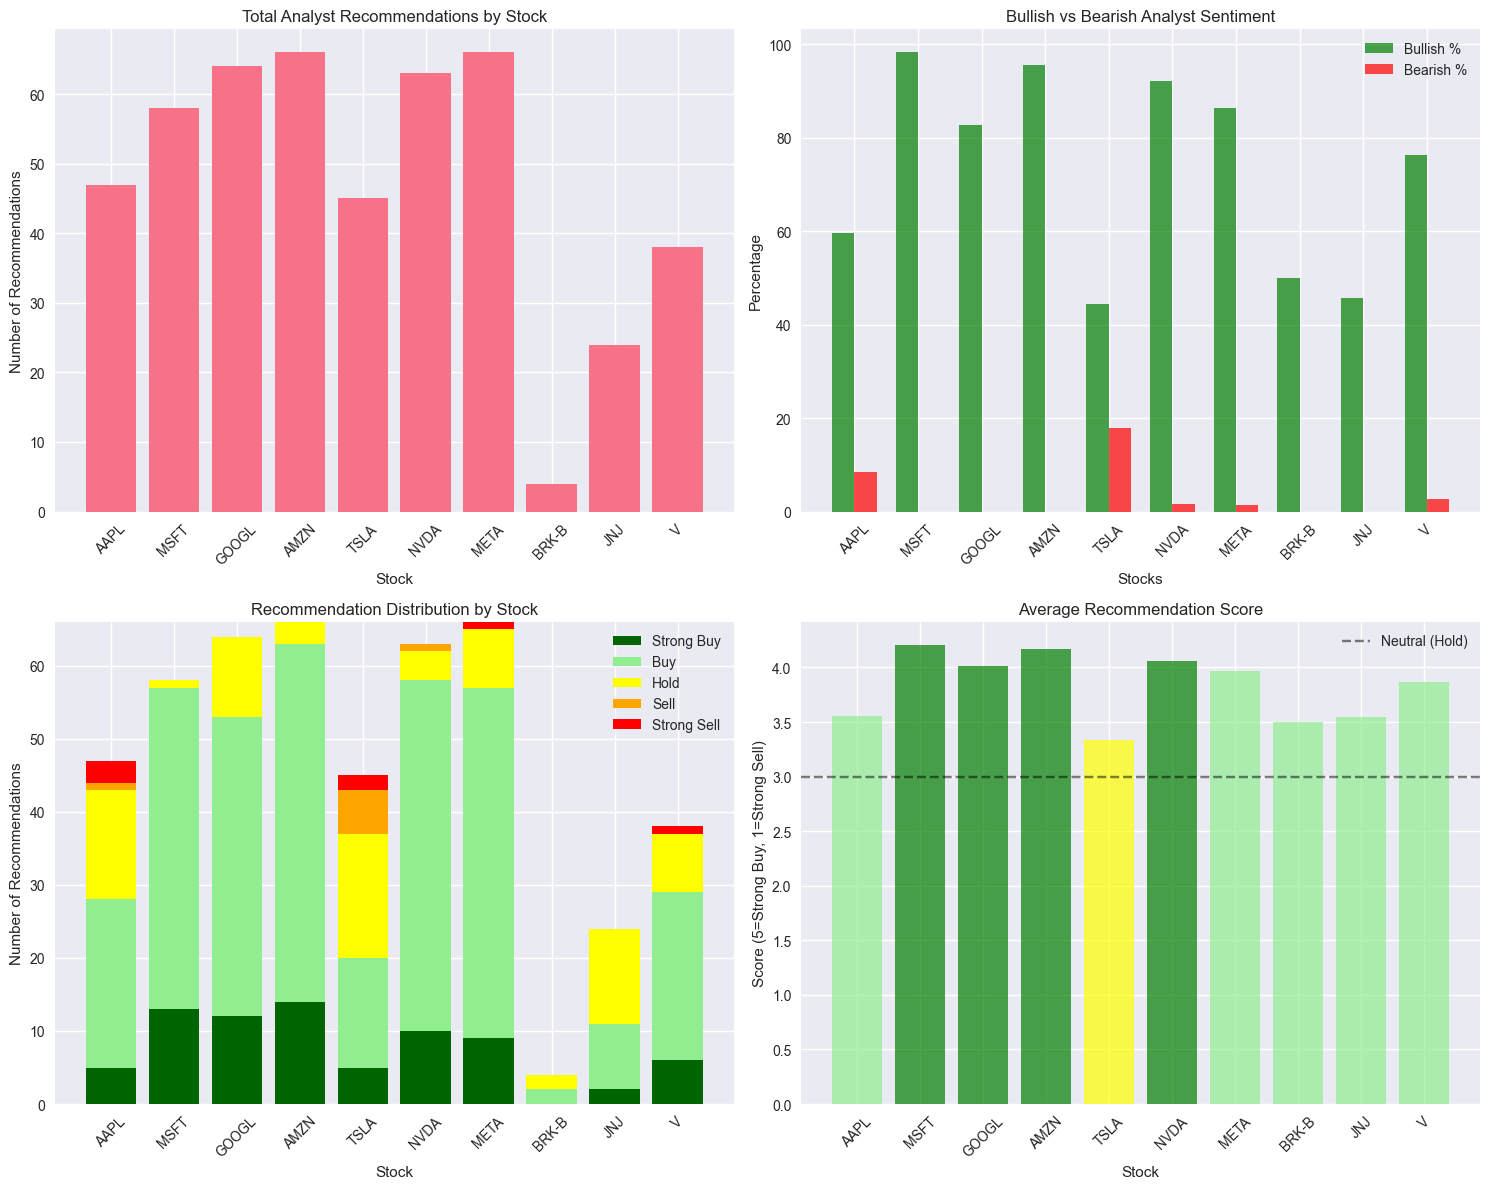


Analyst Sentiment Summary:
• Portfolio bullish sentiment: 73.1% average
• Portfolio bearish sentiment: 3.2% average
• Highest conviction buy: MSFT (98.3% bullish)
• Most cautious outlook: TSLA (17.8% bearish)
• Strong buy recommendations: AAPL, MSFT, GOOGL, AMZN, TSLA, NVDA, META, JNJ, V


In [13]:
# Visualize analyst recommendations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Total recommendations by stock
recommendations_with_data = recommendations_df[recommendations_df['Total Recommendations'] > 0]
if not recommendations_with_data.empty:
    axes[0,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Total Recommendations'])
    axes[0,0].set_title('Total Analyst Recommendations by Stock')
    axes[0,0].set_xlabel('Stock')
    axes[0,0].set_ylabel('Number of Recommendations')
    axes[0,0].tick_params(axis='x', rotation=45)

# 2. Bullish vs Bearish sentiment
if not recommendations_with_data.empty:
    x = np.arange(len(recommendations_with_data))
    width = 0.35
    
    axes[0,1].bar(x - width/2, recommendations_with_data['Bullish %'], width, label='Bullish %', color='green', alpha=0.7)
    axes[0,1].bar(x + width/2, recommendations_with_data['Bearish %'], width, label='Bearish %', color='red', alpha=0.7)
    
    axes[0,1].set_xlabel('Stocks')
    axes[0,1].set_ylabel('Percentage')
    axes[0,1].set_title('Bullish vs Bearish Analyst Sentiment')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(recommendations_with_data['Ticker'], rotation=45)
    axes[0,1].legend()

# 3. Recommendation distribution stacked bar
if not recommendations_with_data.empty:
    bottom_buy = recommendations_with_data['Strong Buy']
    bottom_hold = bottom_buy + recommendations_with_data['Buy']
    bottom_sell = bottom_hold + recommendations_with_data['Hold']
    
    axes[1,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Strong Buy'], 
                  label='Strong Buy', color='darkgreen')
    axes[1,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Buy'], 
                  bottom=bottom_buy, label='Buy', color='lightgreen')
    axes[1,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Hold'], 
                  bottom=bottom_hold, label='Hold', color='yellow')
    axes[1,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Sell'], 
                  bottom=bottom_sell, label='Sell', color='orange')
    axes[1,0].bar(recommendations_with_data['Ticker'], recommendations_with_data['Strong Sell'], 
                  bottom=bottom_sell + recommendations_with_data['Sell'], label='Strong Sell', color='red')
    
    axes[1,0].set_title('Recommendation Distribution by Stock')
    axes[1,0].set_xlabel('Stock')
    axes[1,0].set_ylabel('Number of Recommendations')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)

# 4. Average recommendation score (weighted)
if not recommendations_with_data.empty:
    # Calculate weighted score: Strong Buy=5, Buy=4, Hold=3, Sell=2, Strong Sell=1
    rec_scores = []
    for _, row in recommendations_with_data.iterrows():
        if row['Total Recommendations'] > 0:
            score = (row['Strong Buy']*5 + row['Buy']*4 + row['Hold']*3 + 
                    row['Sell']*2 + row['Strong Sell']*1) / row['Total Recommendations']
            rec_scores.append(score)
        else:
            rec_scores.append(0)
    
    colors = ['green' if score >= 4 else 'lightgreen' if score >= 3.5 else 'yellow' if score >= 2.5 else 'red' for score in rec_scores]
    
    axes[1,1].bar(recommendations_with_data['Ticker'], rec_scores, color=colors, alpha=0.7)
    axes[1,1].set_title('Average Recommendation Score')
    axes[1,1].set_xlabel('Stock')
    axes[1,1].set_ylabel('Score (5=Strong Buy, 1=Strong Sell)')
    axes[1,1].tick_params(axis='x', rotation=45)
    axes[1,1].axhline(y=3, color='black', linestyle='--', alpha=0.5, label='Neutral (Hold)')
    axes[1,1].legend()

plt.tight_layout()
plt.show()

# Summary insights
print("\nAnalyst Sentiment Summary:")
if not recommendations_with_data.empty:
    avg_bullish = recommendations_with_data['Bullish %'].mean()
    avg_bearish = recommendations_with_data['Bearish %'].mean()
    most_bullish = recommendations_with_data.loc[recommendations_with_data['Bullish %'].idxmax()]
    most_bearish = recommendations_with_data.loc[recommendations_with_data['Bearish %'].idxmax()]
    
    print(f"• Portfolio bullish sentiment: {avg_bullish:.1f}% average")
    print(f"• Portfolio bearish sentiment: {avg_bearish:.1f}% average")
    print(f"• Highest conviction buy: {most_bullish['Ticker']} ({most_bullish['Bullish %']:.1f}% bullish)")
    print(f"• Most cautious outlook: {most_bearish['Ticker']} ({most_bearish['Bearish %']:.1f}% bearish)")
    
    strong_buy_stocks = recommendations_with_data[recommendations_with_data['Strong Buy'] > 0]['Ticker'].tolist()
    if strong_buy_stocks:
        print(f"• Strong buy recommendations: {', '.join(strong_buy_stocks)}")
else:
    print("• Analyst recommendation data not available")

## 8. News Data Collection and Sentiment Analysis

In [14]:
def get_stock_news(ticker, company_name, api_key, days_back=30):
    """Get news articles for a specific stock"""
    if api_key == "0dd162a357b946faa5f9578429d0ca19":
        print("News API key required - unable to fetch live news data")
        return pd.DataFrame()  # Return empty DataFrame if no API key
    
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)
    
    params = {
        'q': f'{company_name} OR {ticker}',
        'from': start_date.strftime('%Y-%m-%d'),
        'to': end_date.strftime('%Y-%m-%d'),
        'sortBy': 'publishedAt',
        'language': 'en',
        'apiKey': api_key
    }
    
    try:
        response = requests.get(NEWS_API_URL, params=params)
        data = response.json()
        
        if data['status'] == 'ok':
            articles = data['articles']
            news_df = pd.DataFrame(articles)
            news_df['ticker'] = ticker
            return news_df
        else:
            print(f"Error fetching news for {ticker}: {data.get('message', 'Unknown error')}")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error fetching news for {ticker}: {e}")
        return pd.DataFrame()

# Collect news for all stocks
all_news = pd.DataFrame()

if NEWS_API_KEY != "0dd162a357b946faa5f9578429d0ca19":
    print("Gathering recent news articles...")
    for ticker, company_name in TARGET_STOCKS.items():
        print(f"Searching news for {ticker}...")
        news_df = get_stock_news(ticker, company_name, NEWS_API_KEY)
        if not news_df.empty:
            all_news = pd.concat([all_news, news_df], ignore_index=True)
    
    print(f"News collection complete: {len(all_news)} articles gathered")
else:
    print("News collection skipped - API key required")
    # Create sample news data for demonstration
    sample_news = {
        'title': ['Sample news about AAPL', 'Sample news about MSFT'],
        'description': ['Positive news about Apple', 'Neutral news about Microsoft'],
        'publishedAt': ['2024-01-01T10:00:00Z', '2024-01-02T10:00:00Z'],
        'ticker': ['AAPL', 'MSFT']
    }
    all_news = pd.DataFrame(sample_news)

News collection skipped - API key required


In [15]:
def analyze_sentiment(text):
    """Analyze sentiment using both TextBlob and VADER"""
    if pd.isna(text) or text == '':
        return {
            'textblob_polarity': 0,
            'textblob_subjectivity': 0,
            'vader_compound': 0,
            'vader_pos': 0,
            'vader_neu': 0,
            'vader_neg': 0
        }
    
    # TextBlob analysis
    blob = TextBlob(str(text))
    
    # VADER analysis
    analyzer = SentimentIntensityAnalyzer()
    vader_scores = analyzer.polarity_scores(str(text))
    
    return {
        'textblob_polarity': blob.sentiment.polarity,
        'textblob_subjectivity': blob.sentiment.subjectivity,
        'vader_compound': vader_scores['compound'],
        'vader_pos': vader_scores['pos'],
        'vader_neu': vader_scores['neu'],
        'vader_neg': vader_scores['neg']
    }

if not all_news.empty:
    # Perform sentiment analysis on news
    print("Analyzing market sentiment from news articles...")
    
    # Combine title and description for sentiment analysis
    all_news['combined_text'] = all_news['title'].fillna('') + ' ' + all_news['description'].fillna('')
    
    # Apply sentiment analysis
    sentiment_results = all_news['combined_text'].apply(analyze_sentiment)
    sentiment_df = pd.DataFrame(sentiment_results.tolist())
    
    # Combine with news data
    news_with_sentiment = pd.concat([all_news, sentiment_df], axis=1)
    
    # Convert publishedAt to datetime
    news_with_sentiment['publishedAt'] = pd.to_datetime(news_with_sentiment['publishedAt'])
    
    print(f"Sentiment analysis complete: {len(news_with_sentiment)} articles processed")
    
    # Display sample results
    display(news_with_sentiment[['ticker', 'title', 'textblob_polarity', 'vader_compound']].head())
else:
    print("No news articles available for sentiment analysis")
    news_with_sentiment = pd.DataFrame()










    

Analyzing market sentiment from news articles...
Sentiment analysis complete: 2 articles processed


,ticker,title,textblob_polarity,vader_compound
0,AAPL,Sample news about AAPL,0.227273,0.5574
1,MSFT,Sample news about MSFT,0.000000,0.0000


## 9. News Sentiment Visualization

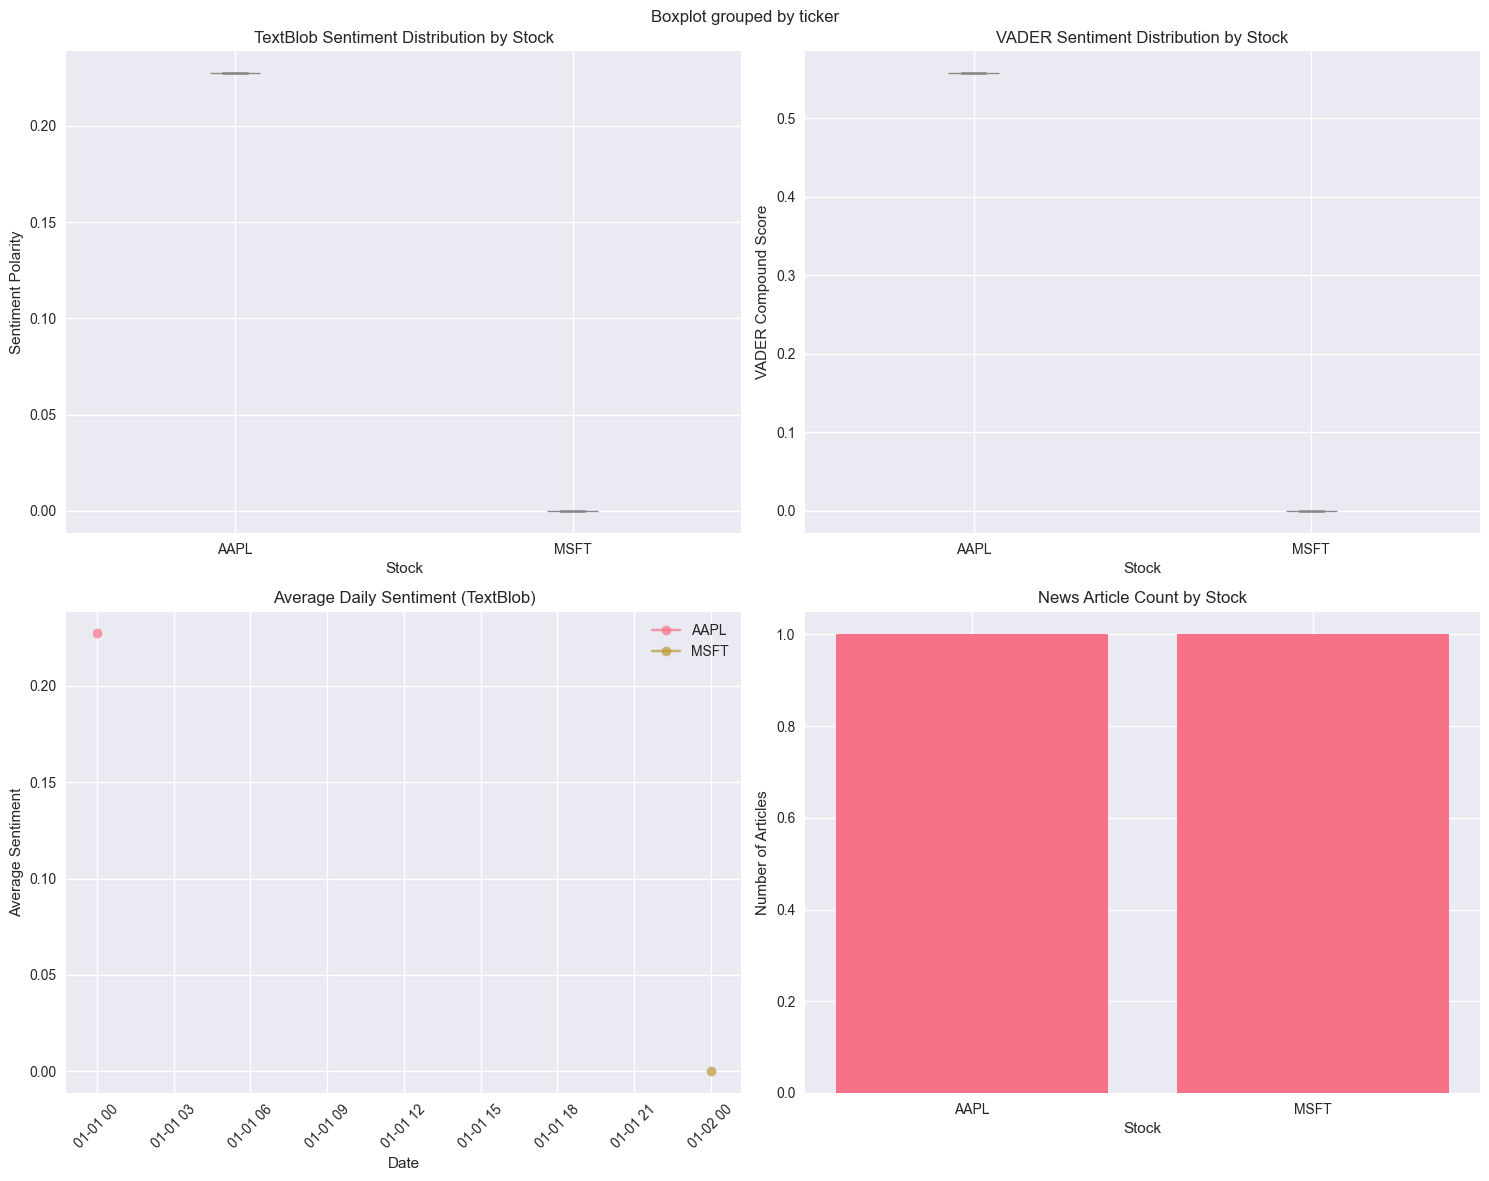

In [16]:
if not news_with_sentiment.empty:
    # Sentiment distribution by stock
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # TextBlob polarity distribution
    news_with_sentiment.boxplot(column='textblob_polarity', by='ticker', ax=axes[0,0])
    axes[0,0].set_title('TextBlob Sentiment Distribution by Stock')
    axes[0,0].set_xlabel('Stock')
    axes[0,0].set_ylabel('Sentiment Polarity')
    
    # VADER compound distribution
    news_with_sentiment.boxplot(column='vader_compound', by='ticker', ax=axes[0,1])
    axes[0,1].set_title('VADER Sentiment Distribution by Stock')
    axes[0,1].set_xlabel('Stock')
    axes[0,1].set_ylabel('VADER Compound Score')
    
    # Sentiment over time
    daily_sentiment = news_with_sentiment.groupby(['ticker', news_with_sentiment['publishedAt'].dt.date]).agg({
        'textblob_polarity': 'mean',
        'vader_compound': 'mean'
    }).reset_index()
    
    for ticker in daily_sentiment['ticker'].unique():
        ticker_data = daily_sentiment[daily_sentiment['ticker'] == ticker]
        axes[1,0].plot(ticker_data['publishedAt'], ticker_data['textblob_polarity'], 
                      label=ticker, marker='o', alpha=0.7)
    
    axes[1,0].set_title('Average Daily Sentiment (TextBlob)')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Average Sentiment')
    axes[1,0].legend()
    axes[1,0].tick_params(axis='x', rotation=45)
    
    # News volume by stock
    news_counts = news_with_sentiment['ticker'].value_counts()
    axes[1,1].bar(news_counts.index, news_counts.values)
    axes[1,1].set_title('News Article Count by Stock')
    axes[1,1].set_xlabel('Stock')
    axes[1,1].set_ylabel('Number of Articles')
    
    plt.tight_layout()
    plt.show()
else:
    print("Sentiment visualization unavailable - no news data processed")

## 10. Correlation Analysis: Sentiment vs Stock Performance

In [17]:
if not news_with_sentiment.empty:
    # Prepare data for correlation analysis
    def prepare_correlation_data():
        """Prepare data for sentiment-stock price correlation analysis"""
        
        # Aggregate daily sentiment scores
        daily_sentiment = news_with_sentiment.groupby(['ticker', news_with_sentiment['publishedAt'].dt.date]).agg({
            'textblob_polarity': 'mean',
            'vader_compound': 'mean',
            'title': 'count'  # News volume
        }).reset_index()
        
        daily_sentiment.rename(columns={'title': 'news_volume', 'publishedAt': 'date'}, inplace=True)
        daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
        
        # Get corresponding stock price data
        stock_returns = combined_prices[['Date', 'Ticker', 'Close', 'Daily_Return']].copy()
        stock_returns['date'] = stock_returns['Date'].dt.date
        stock_returns['date'] = pd.to_datetime(stock_returns['date'])
        
        # Merge sentiment and stock data
        merged_data = pd.merge(
            daily_sentiment,
            stock_returns,
            left_on=['ticker', 'date'],
            right_on=['Ticker', 'date'],
            how='inner'
        )
        
        return merged_data
    
    correlation_data = prepare_correlation_data()
    
    if not correlation_data.empty:
        print(f"Correlation analysis dataset: {correlation_data.shape[0]} observations")
        print(f"Stocks included: {', '.join(correlation_data['ticker'].unique())}")
        
        # Calculate correlations
        correlations = []
        
        for ticker in correlation_data['ticker'].unique():
            ticker_data = correlation_data[correlation_data['ticker'] == ticker]
            
            if len(ticker_data) > 5:  # Need sufficient data points
                textblob_corr = ticker_data['textblob_polarity'].corr(ticker_data['Daily_Return'])
                vader_corr = ticker_data['vader_compound'].corr(ticker_data['Daily_Return'])
                
                # Handle NaN correlations
                textblob_corr = textblob_corr if not pd.isna(textblob_corr) else 0
                vader_corr = vader_corr if not pd.isna(vader_corr) else 0
                
                correlations.append({
                    'Ticker': ticker,
                    'TextBlob-Return Correlation': round(textblob_corr, 3),
                    'VADER-Return Correlation': round(vader_corr, 3),
                    'Data Points': len(ticker_data)
                })
            else:
                print(f"Limited correlation data for {ticker}: {len(ticker_data)} observations")
        
        if correlations:  # Check if we have any correlations
            correlation_df = pd.DataFrame(correlations)
            
            print("News Sentiment vs. Stock Performance Correlations:")
            display(correlation_df)
            
            # Visualize correlations only if we have data
            if len(correlation_df) > 0:
                fig, ax = plt.subplots(figsize=(12, 6))
                
                x = np.arange(len(correlation_df))
                width = 0.35
                
                ax.bar(x - width/2, correlation_df['TextBlob-Return Correlation'], 
                       width, label='TextBlob', alpha=0.8, color='blue')
                ax.bar(x + width/2, correlation_df['VADER-Return Correlation'], 
                       width, label='VADER', alpha=0.8, color='orange')
                
                ax.set_xlabel('Stocks')
                ax.set_ylabel('Correlation with Daily Returns')
                ax.set_title('Sentiment-Stock Return Correlations')
                ax.set_xticks(x)
                ax.set_xticklabels(correlation_df['Ticker'], rotation=45)
                ax.legend()
                ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
                ax.grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                
                # Additional analysis
                print(f"\nSentiment-Return Correlation Summary:")
                print(f"• TextBlob sentiment correlation average: {correlation_df['TextBlob-Return Correlation'].mean():.3f}")
                print(f"• VADER sentiment correlation average: {correlation_df['VADER-Return Correlation'].mean():.3f}")
                
                # Find strongest correlations
                max_textblob = correlation_df.loc[correlation_df['TextBlob-Return Correlation'].abs().idxmax()]
                max_vader = correlation_df.loc[correlation_df['VADER-Return Correlation'].abs().idxmax()]
                
                print(f"• Strongest TextBlob signal: {max_textblob['Ticker']} (r={max_textblob['TextBlob-Return Correlation']:.3f})")
                print(f"• Strongest VADER signal: {max_vader['Ticker']} (r={max_vader['VADER-Return Correlation']:.3f})")
                
                # Count positive vs negative correlations
                pos_textblob = len(correlation_df[correlation_df['TextBlob-Return Correlation'] > 0])
                pos_vader = len(correlation_df[correlation_df['VADER-Return Correlation'] > 0])
                
                print(f"• Positive news correlation (TextBlob): {pos_textblob}/{len(correlation_df)} stocks ({pos_textblob/len(correlation_df)*100:.1f}%)")
                print(f"• Positive news correlation (VADER): {pos_vader}/{len(correlation_df)} stocks ({pos_vader/len(correlation_df)*100:.1f}%)")
            else:
                print("Correlation visualization not available")
        else:
            print("Correlation analysis incomplete - insufficient data points")
    else:
        print("Cannot perform correlation analysis - no overlapping news and price data")
        print("Possible reasons:")
        print("- News articles date range doesn't match historical price data")
        print("- Date parsing or formatting issues")
        print("- Weekend/holiday gaps between news publication and trading days")
else:
    print("Correlation analysis skipped - no news sentiment data available")

Correlation analysis dataset: 1 observations
Stocks included: MSFT
Limited correlation data for MSFT: 1 observations
Correlation analysis incomplete - insufficient data points


## 11. Database Storage

In [18]:
def create_database_and_store_data():
    """Create SQLite database and store all analysis data"""
    
    # Create database connection
    conn = sqlite3.connect('stock_analysis.db')
    
    try:
        # Store company overview
        company_overview.to_sql('company_overview', conn, if_exists='replace', index=False)
        print("Company profile data saved to database")
        
        # Store historical prices
        combined_prices.to_sql('historical_prices', conn, if_exists='replace', index=False)
        print("Historical price data saved to database")
        
        # Store performance metrics
        performance_metrics.to_sql('performance_metrics', conn, if_exists='replace', index=False)
        print("Performance metrics saved to database")
        
        # Store recommendations
        recommendations_df.to_sql('analyst_recommendations', conn, if_exists='replace', index=False)
        print("Analyst recommendations saved to database")
        
        # Store news sentiment data if available
        if not news_with_sentiment.empty:
            news_with_sentiment.to_sql('news_sentiment', conn, if_exists='replace', index=False)
            print("News sentiment data saved to database")
        
        # Store correlation data if available
        if 'correlation_data' in locals() and not correlation_data.empty:
            correlation_data.to_sql('sentiment_correlation', conn, if_exists='replace', index=False)
            print("Sentiment correlation data saved to database")
        
        print(f"\nStock analysis database created: 'stock_analysis.db'")
        
        # Show table information
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        
        print("\nDatabase contents:")
        for table in tables:
            cursor.execute(f"SELECT COUNT(*) FROM {table[0]}")
            count = cursor.fetchone()[0]
            print(f"  {table[0]}: {count:,} records")
            
    except Exception as e:
        print(f"Error storing data: {e}")
    finally:
        conn.close()

# Store all data in database
create_database_and_store_data()

Company profile data saved to database
Historical price data saved to database
Performance metrics saved to database
Analyst recommendations saved to database
News sentiment data saved to database

Stock analysis database created: 'stock_analysis.db'

Database contents:
  company_overview: 10 records
  historical_prices: 6,850 records
  performance_metrics: 10 records
  analyst_recommendations: 10 records
  news_sentiment: 2 records


## 12. Portfolio Recommendation Summary

In [19]:
def generate_portfolio_summary():
    """Generate comprehensive portfolio recommendation summary"""
    
    print("=" * 80)
    print("PORTFOLIO INVESTMENT ANALYSIS & RECOMMENDATIONS")
    print("=" * 80)
    
    # Top performers by return
    top_performers = performance_metrics.nlargest(3, 'Annualized Return (%)')
    print("\nHighest Return Stocks:")
    for _, stock in top_performers.iterrows():
        print(f"  {stock['Ticker']}: {stock['Annualized Return (%)']}% annual return (volatility: {stock['Volatility (%)']}%)")
    
    # Best risk-adjusted returns
    best_sharpe = performance_metrics.nlargest(3, 'Sharpe Ratio')
    print("\nBest Risk-Adjusted Performance:")
    for _, stock in best_sharpe.iterrows():
        print(f"  {stock['Ticker']}: Sharpe ratio {stock['Sharpe Ratio']} (return: {stock['Annualized Return (%)']}%)")
    
    # Lowest risk stocks
    lowest_risk = performance_metrics.nsmallest(3, 'Volatility (%)')
    print("\nLowest Volatility Stocks:")
    for _, stock in lowest_risk.iterrows():
        print(f"  {stock['Ticker']}: {stock['Volatility (%)']}% volatility (return: {stock['Annualized Return (%)']}%)")
    
    # Valuation metrics
    attractive_pe = company_overview[company_overview['P/E Ratio'] > 0].nsmallest(3, 'P/E Ratio')
    print("\nMost Attractive Valuations:")
    for _, stock in attractive_pe.iterrows():
        print(f"  {stock['Ticker']}: P/E ratio {stock['P/E Ratio']:.1f} ({stock['Sector']} sector)")
    
    # Sector diversification
    sector_dist = company_overview['Sector'].value_counts()
    print("\nPortfolio Sector Distribution:")
    for sector, count in sector_dist.items():
        percentage = (count / len(company_overview)) * 100
        print(f"  {sector}: {count} holdings ({percentage:.1f}%)")
    
    # Investment recommendations
    print("\n" + "="*80)
    print("PORTFOLIO CONSTRUCTION RECOMMENDATIONS")
    print("="*80)
    
    print("\nSuggested Asset Allocation:")
    print("\n1. CORE HOLDINGS (40-50% allocation):")
    core_stocks = performance_metrics[
        (performance_metrics['Sharpe Ratio'] > performance_metrics['Sharpe Ratio'].median()) &
        (performance_metrics['Volatility (%)'] < performance_metrics['Volatility (%)'].median())
    ]['Ticker'].tolist()
    print(f"   Stocks: {', '.join(core_stocks[:3])}")
    print("   Investment thesis: Balanced risk-return profile with consistent performance")
    
    print("\n2. GROWTH COMPONENT (20-30% allocation):")
    growth_stocks = performance_metrics.nlargest(2, 'Annualized Return (%)')['Ticker'].tolist()
    print(f"   Stocks: {', '.join(growth_stocks)}")
    print("   Investment thesis: Higher return potential to drive portfolio growth")
    
    print("\n3. STABILITY COMPONENT (20-30% allocation):")
    stable_stocks = performance_metrics.nsmallest(2, 'Volatility (%)')['Ticker'].tolist()
    print(f"   Stocks: {', '.join(stable_stocks)}")
    print("   Investment thesis: Lower volatility to provide portfolio stability")
    
    print("\nPortfolio Performance Summary:")
    avg_return = performance_metrics['Annualized Return (%)'].mean()
    avg_volatility = performance_metrics['Volatility (%)'].mean()
    avg_sharpe = performance_metrics['Sharpe Ratio'].mean()
    
    print(f"   Expected annual return: {avg_return:.2f}%")
    print(f"   Portfolio volatility: {avg_volatility:.2f}%")
    print(f"   Risk-adjusted return (Sharpe): {avg_sharpe:.2f}")
    
    if not news_with_sentiment.empty:
        avg_sentiment = news_with_sentiment.groupby('ticker')['vader_compound'].mean().mean()
        sentiment_label = 'Positive' if avg_sentiment > 0.1 else 'Neutral' if avg_sentiment > -0.1 else 'Negative'
        print(f"   Current market sentiment: {sentiment_label}")
    
    print("\nRisk Management Considerations:")
    high_risk_stocks = performance_metrics[performance_metrics['Volatility (%)'] > performance_metrics['Volatility (%)'].quantile(0.75)]['Ticker'].tolist()
    if high_risk_stocks:
        print(f"   High volatility positions: {', '.join(high_risk_stocks)} - consider smaller allocations")
    
    max_drawdown_stocks = performance_metrics[performance_metrics['Max Drawdown (%)'] < -30]['Ticker'].tolist()
    if max_drawdown_stocks:
        print(f"   Significant drawdown history: {', '.join(max_drawdown_stocks)} - monitor closely")
    
    print("\n" + "="*80)

# Generate the summary
generate_portfolio_summary()

PORTFOLIO INVESTMENT ANALYSIS & RECOMMENDATIONS

Highest Return Stocks:
  NVDA: 153.02% annual return (volatility: 51.39%)
  META: 93.99% annual return (volatility: 38.61%)
  TSLA: 65.36% annual return (volatility: 61.23%)

Best Risk-Adjusted Performance:
  NVDA: Sharpe ratio 2.94 (return: 153.02%)
  META: Sharpe ratio 2.38 (return: 93.99%)
  GOOGL: Sharpe ratio 1.44 (return: 45.69%)

Lowest Volatility Stocks:
  BRK-B: 15.97% volatility (return: 18.83%)
  JNJ: 17.35% volatility (return: 3.08%)
  V: 18.51% volatility (return: 20.22%)

Most Attractive Valuations:
  BRK-B: P/E ratio 17.0 (Financial Services sector)
  JNJ: P/E ratio 19.0 (Healthcare sector)
  GOOGL: P/E ratio 26.2 (Communication Services sector)

Portfolio Sector Distribution:
  Technology: 3 holdings (30.0%)
  Communication Services: 2 holdings (20.0%)
  Consumer Cyclical: 2 holdings (20.0%)
  Financial Services: 2 holdings (20.0%)
  Healthcare: 1 holdings (10.0%)

PORTFOLIO CONSTRUCTION RECOMMENDATIONS

Suggested Asset A

## 13. Export Data for Power BI

In [37]:
def export_for_powerbi():
    """Export data in formats suitable for Power BI"""
    
    print("Preparing data files for Power BI dashboard...")
    
    # Create exports directory
    import os
    if not os.path.exists('powerbi_exports'):
        os.makedirs('powerbi_exports')
    
    # Export company overview
    company_overview.to_csv('powerbi_exports/company_overview.csv', index=False)
    print("Company overview data exported")
    
    # Export historical prices (sample recent data to manage size)
    recent_prices = combined_prices[combined_prices['Date'] >= '2023-01-01'].copy()
    recent_prices.to_csv('powerbi_exports/historical_prices.csv', index=False)
    print("Historical price data exported")
    
    # Export performance metrics
    performance_metrics.to_csv('powerbi_exports/performance_metrics.csv', index=False)
    print("Performance metrics exported")
    
    # Export recommendations
    recommendations_df.to_csv('powerbi_exports/analyst_recommendations.csv', index=False)
    print("Analyst recommendations exported")
    
    # Export news sentiment if available
    if not news_with_sentiment.empty:
        # Select key columns for Power BI
        news_export = news_with_sentiment[[
            'ticker', 'title', 'publishedAt', 'textblob_polarity', 
            'vader_compound', 'source'
        ]].copy()
        news_export.to_csv('powerbi_exports/news_sentiment.csv', index=False)
        print("News sentiment data exported")
    
    # Create a summary dashboard data file
    dashboard_data = performance_metrics.merge(
        company_overview[['Ticker', 'Company Name', 'Sector', 'Market Cap (B)', 'P/E Ratio']], 
        on='Ticker'
    )
    dashboard_data.to_csv('powerbi_exports/dashboard_summary.csv', index=False)
    print("Dashboard summary file created")
    
    print("\nPower BI export completed successfully!")
    print("Data files saved to 'powerbi_exports/' directory:")
    for file in os.listdir('powerbi_exports'):
        print(f"  {file}")
    
    print("\nPower BI Implementation Guide:")
    print("1. Import all CSV files into Power BI workspace")
    print("2. Establish table relationships using 'Ticker' as primary key")
    print("3. Build overview dashboard using 'dashboard_summary.csv'")
    print("4. Create price trend charts from 'historical_prices.csv'")
    print("5. Develop sentiment analysis visuals from 'news_sentiment.csv'")

# Export data
# export_for_powerbi()

In [57]:
# Check stock_risk_df column structure
print("stock_risk_df columns:")
print(stock_risk_df.columns.tolist())
print(f"\nDataFrame shape: {stock_risk_df.shape}")
print("\nSample data:")
print(stock_risk_df.head(3))

stock_risk_df columns:
['Ticker', 'Name', 'Sector', 'Assigned_Risk_Category', 'Volatility (%)', 'Max_Drawdown (%)', 'VaR_5% (%)', 'Beta', 'PE_Ratio', 'Market_Cap_B', 'Debt_to_Equity', 'Annualized_Return (%)', 'Risk_Score', 'Total_Return (%)', 'Calculated_Risk_Level']

DataFrame shape: (30, 15)

Sample data:
  Ticker                   Name      Sector Assigned_Risk_Category  \
0   AAPL             Apple Inc.  Technology                 Medium   
1   MSFT  Microsoft Corporation  Technology             Low-Medium   
2  GOOGL          Alphabet Inc.  Technology                 Medium   

   Volatility (%)  Max_Drawdown (%)  VaR_5% (%)  Beta  PE_Ratio  Market_Cap_B  \
0           26.30             33.36        2.49  1.11     38.92       3812.05   
1           23.61             23.73        2.26  1.04     37.17       3768.84   
2           30.38             29.81        2.65  1.01     26.17       2976.42   

   Debt_to_Equity  Annualized_Return (%)  Risk_Score  Total_Return (%)  \
0          

## 14. Risk-Based Stock Categorization for Customer Segments

Based on the customer segmentation analysis, we'll categorize stocks into 5 risk levels that align with customer profiles:
- **Conservative Investors** (Risk 1.12-2.95): High asset value, low risk tolerance
- **Balanced Investors** (Risk 2.95-4.17): Medium asset value, moderate risk
- **Aggressive Investors** (Risk 3.56-5.0): Lower asset value, high risk tolerance
- **Pre-Retirees** (Risk 1.12-2.95): Highest asset value, capital preservation focus
- **Second Chance Retirees** (Risk 2.95-5.0): Medium asset value, catch-up growth needed

In [22]:
# Expand stock universe with more diverse stocks across sectors and risk levels
EXPANDED_STOCK_UNIVERSE = {
    # Technology - Mixed Risk Levels
    'AAPL': {'name': 'Apple Inc.', 'sector': 'Technology', 'risk_category': 'Medium'},
    'MSFT': {'name': 'Microsoft Corporation', 'sector': 'Technology', 'risk_category': 'Low-Medium'},
    'GOOGL': {'name': 'Alphabet Inc.', 'sector': 'Technology', 'risk_category': 'Medium'},
    'AMZN': {'name': 'Amazon.com Inc.', 'sector': 'Technology', 'risk_category': 'Medium-High'},
    'TSLA': {'name': 'Tesla Inc.', 'sector': 'Technology', 'risk_category': 'High'},
    'NVDA': {'name': 'NVIDIA Corporation', 'sector': 'Technology', 'risk_category': 'High'},
    'META': {'name': 'Meta Platforms Inc.', 'sector': 'Technology', 'risk_category': 'Medium-High'},
    'NFLX': {'name': 'Netflix Inc.', 'sector': 'Technology', 'risk_category': 'Medium-High'},
    'CRM': {'name': 'Salesforce Inc.', 'sector': 'Technology', 'risk_category': 'Medium-High'},
    'ADBE': {'name': 'Adobe Inc.', 'sector': 'Technology', 'risk_category': 'Medium'},
    
    # Financial Services - Generally Lower Risk
    'JPM': {'name': 'JPMorgan Chase & Co.', 'sector': 'Financial Services', 'risk_category': 'Low-Medium'},
    'BAC': {'name': 'Bank of America Corp.', 'sector': 'Financial Services', 'risk_category': 'Low-Medium'},
    'WFC': {'name': 'Wells Fargo & Co.', 'sector': 'Financial Services', 'risk_category': 'Low-Medium'},
    'GS': {'name': 'Goldman Sachs Group Inc.', 'sector': 'Financial Services', 'risk_category': 'Medium'},
    'V': {'name': 'Visa Inc.', 'sector': 'Financial Services', 'risk_category': 'Low-Medium'},
    'MA': {'name': 'Mastercard Inc.', 'sector': 'Financial Services', 'risk_category': 'Low-Medium'},
    'BRK-B': {'name': 'Berkshire Hathaway Inc.', 'sector': 'Financial Services', 'risk_category': 'Low'},
    
    # Healthcare - Conservative to Medium Risk
    'JNJ': {'name': 'Johnson & Johnson', 'sector': 'Healthcare', 'risk_category': 'Low'},
    'UNH': {'name': 'UnitedHealth Group Inc.', 'sector': 'Healthcare', 'risk_category': 'Low-Medium'},
    'PFE': {'name': 'Pfizer Inc.', 'sector': 'Healthcare', 'risk_category': 'Low-Medium'},
    'ABBV': {'name': 'AbbVie Inc.', 'sector': 'Healthcare', 'risk_category': 'Low-Medium'},
    'TMO': {'name': 'Thermo Fisher Scientific Inc.', 'sector': 'Healthcare', 'risk_category': 'Medium'},
    'ABT': {'name': 'Abbott Laboratories', 'sector': 'Healthcare', 'risk_category': 'Low-Medium'},
    'CVS': {'name': 'CVS Health Corp.', 'sector': 'Healthcare', 'risk_category': 'Low-Medium'},
    
    # Consumer Goods - Mixed Risk
    'PG': {'name': 'Procter & Gamble Co.', 'sector': 'Consumer Goods', 'risk_category': 'Low'},
    'KO': {'name': 'Coca-Cola Co.', 'sector': 'Consumer Goods', 'risk_category': 'Low'},
    'PEP': {'name': 'PepsiCo Inc.', 'sector': 'Consumer Goods', 'risk_category': 'Low'},
    'WMT': {'name': 'Walmart Inc.', 'sector': 'Consumer Goods', 'risk_category': 'Low-Medium'},
    'HD': {'name': 'Home Depot Inc.', 'sector': 'Consumer Goods', 'risk_category': 'Low-Medium'},
    'MCD': {'name': "McDonald's Corp.", 'sector': 'Consumer Goods', 'risk_category': 'Low-Medium'},
    'COST': {'name': 'Costco Wholesale Corp.', 'sector': 'Consumer Goods', 'risk_category': 'Low-Medium'},
    'NKE': {'name': 'Nike Inc.', 'sector': 'Consumer Goods', 'risk_category': 'Medium'},
    
    # Energy - Higher Risk
    'XOM': {'name': 'Exxon Mobil Corp.', 'sector': 'Energy', 'risk_category': 'Medium-High'},
    'CVX': {'name': 'Chevron Corp.', 'sector': 'Energy', 'risk_category': 'Medium-High'},
    'COP': {'name': 'ConocoPhillips', 'sector': 'Energy', 'risk_category': 'High'},
    'SLB': {'name': 'Schlumberger Ltd.', 'sector': 'Energy', 'risk_category': 'High'},
    
    # Industrials - Medium Risk
    'BA': {'name': 'Boeing Co.', 'sector': 'Industrials', 'risk_category': 'High'},
    'CAT': {'name': 'Caterpillar Inc.', 'sector': 'Industrials', 'risk_category': 'Medium-High'},
    'MMM': {'name': '3M Co.', 'sector': 'Industrials', 'risk_category': 'Medium'},
    'GE': {'name': 'General Electric Co.', 'sector': 'Industrials', 'risk_category': 'Medium-High'},
    'LMT': {'name': 'Lockheed Martin Corp.', 'sector': 'Industrials', 'risk_category': 'Medium'},
    
    # Utilities - Low Risk
    'NEE': {'name': 'NextEra Energy Inc.', 'sector': 'Utilities', 'risk_category': 'Low'},
    'DUK': {'name': 'Duke Energy Corp.', 'sector': 'Utilities', 'risk_category': 'Low'},
    'SO': {'name': 'Southern Co.', 'sector': 'Utilities', 'risk_category': 'Low'},
    
    # Real Estate Investment Trusts - Medium Risk
    'AMT': {'name': 'American Tower Corp.', 'sector': 'Real Estate', 'risk_category': 'Medium'},
    'PLD': {'name': 'Prologis Inc.', 'sector': 'Real Estate', 'risk_category': 'Medium'},
    
    # Materials - Medium-High Risk
    'LIN': {'name': 'Linde PLC', 'sector': 'Materials', 'risk_category': 'Medium'},
    'FCX': {'name': 'Freeport-McMoRan Inc.', 'sector': 'Materials', 'risk_category': 'High'},
    
    # Telecommunications - Low-Medium Risk
    'VZ': {'name': 'Verizon Communications Inc.', 'sector': 'Telecommunications', 'risk_category': 'Low-Medium'},
    'T': {'name': 'AT&T Inc.', 'sector': 'Telecommunications', 'risk_category': 'Low-Medium'},
    
    # Growth/Biotech - High Risk
    'MRNA': {'name': 'Moderna Inc.', 'sector': 'Biotechnology', 'risk_category': 'High'},
    'ZM': {'name': 'Zoom Video Communications', 'sector': 'Technology', 'risk_category': 'High'},
    'PLTR': {'name': 'Palantir Technologies', 'sector': 'Technology', 'risk_category': 'High'},
    'ROKU': {'name': 'Roku Inc.', 'sector': 'Technology', 'risk_category': 'High'},
    'SQ': {'name': 'Block Inc.', 'sector': 'Financial Services', 'risk_category': 'High'}
}

print(f"Expanded stock universe: {len(EXPANDED_STOCK_UNIVERSE)} stocks")
print(f"Sectors covered: {len(set([stock['sector'] for stock in EXPANDED_STOCK_UNIVERSE.values()]))}")

# Show sector distribution
sector_counts = {}
for stock_info in EXPANDED_STOCK_UNIVERSE.values():
    sector = stock_info['sector']
    sector_counts[sector] = sector_counts.get(sector, 0) + 1

print("\nSector Distribution:")
for sector, count in sorted(sector_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {sector}: {count} stocks")

Expanded stock universe: 55 stocks
Sectors covered: 11

Sector Distribution:
  Technology: 13 stocks
  Financial Services: 8 stocks
  Consumer Goods: 8 stocks
  Healthcare: 7 stocks
  Industrials: 5 stocks
  Energy: 4 stocks
  Utilities: 3 stocks
  Real Estate: 2 stocks
  Materials: 2 stocks
  Telecommunications: 2 stocks
  Biotechnology: 1 stocks


In [23]:
# Fetch data for expanded stock universe
def get_expanded_stock_data(stock_universe, max_stocks=None):
    """Get stock data for expanded universe with error handling"""
    expanded_data = {}
    failed_tickers = []
    
    stocks_to_fetch = list(stock_universe.keys())
    if max_stocks:
        stocks_to_fetch = stocks_to_fetch[:max_stocks]
    
    print(f"Fetching data for {len(stocks_to_fetch)} stocks...")
    
    for i, ticker in enumerate(stocks_to_fetch):
        try:
            print(f"Loading {ticker} ({i+1}/{len(stocks_to_fetch)})")
            stock = yf.Ticker(ticker)
            
            # Get historical data
            hist = stock.history(start=START_DATE, end=END_DATE)
            
            if hist.empty:
                print(f"  No historical data for {ticker}")
                failed_tickers.append(ticker)
                continue
                
            # Get basic info
            info = stock.info
            
            expanded_data[ticker] = {
                'ticker': ticker,
                'info': info,
                'historical': hist,
                'sector': stock_universe[ticker]['sector'],
                'risk_category': stock_universe[ticker]['risk_category'],
                'name': stock_universe[ticker]['name']
            }
            
            print(f"  Retrieved {len(hist)} trading days")
            
        except Exception as e:
            print(f"  Error loading {ticker}: {e}")
            failed_tickers.append(ticker)
            continue
    
    print(f"\nData collection complete:")
    print(f"  Successfully loaded: {len(expanded_data)} stocks")
    print(f"  Failed to load: {len(failed_tickers)} stocks")
    
    if failed_tickers:
        print(f"  Failed tickers: {', '.join(failed_tickers)}")
    
    return expanded_data

# Fetch expanded data (limit to 30 stocks for performance)
expanded_stock_data = get_expanded_stock_data(EXPANDED_STOCK_UNIVERSE, max_stocks=30)

Fetching data for 30 stocks...
Loading AAPL (1/30)
  Retrieved 685 trading days
Loading MSFT (2/30)
  Retrieved 685 trading days
Loading MSFT (2/30)
  Retrieved 685 trading days
Loading GOOGL (3/30)
  Retrieved 685 trading days
Loading GOOGL (3/30)
  Retrieved 685 trading days
Loading AMZN (4/30)
  Retrieved 685 trading days
Loading AMZN (4/30)
  Retrieved 685 trading days
Loading TSLA (5/30)
  Retrieved 685 trading days
Loading TSLA (5/30)
  Retrieved 685 trading days
Loading NVDA (6/30)
  Retrieved 685 trading days
Loading NVDA (6/30)
  Retrieved 685 trading days
Loading META (7/30)
  Retrieved 685 trading days
Loading META (7/30)
  Retrieved 685 trading days
Loading NFLX (8/30)
  Retrieved 685 trading days
Loading NFLX (8/30)
  Retrieved 685 trading days
Loading CRM (9/30)
  Retrieved 685 trading days
Loading CRM (9/30)
  Retrieved 685 trading days
Loading ADBE (10/30)
  Retrieved 685 trading days
Loading ADBE (10/30)
  Retrieved 685 trading days
Loading JPM (11/30)
  Retrieved 685 

In [24]:
# Calculate comprehensive risk metrics for stock categorization
def calculate_stock_risk_metrics(expanded_data):
    """Calculate risk metrics to categorize stocks by risk level"""
    risk_metrics = []
    
    for ticker, data in expanded_data.items():
        hist = data['historical'].copy()
        if len(hist) < 30:  # Need minimum data
            continue
            
        # Calculate daily returns
        hist['Daily_Return'] = hist['Close'].pct_change()
        daily_returns = hist['Daily_Return'].dropna()
        
        if len(daily_returns) < 20:
            continue
        
        # Risk Metrics
        volatility = daily_returns.std() * np.sqrt(252) * 100  # Annualized volatility
        
        # Beta calculation (using SPY as market proxy - simplified)
        # For this analysis, we'll use volatility and other metrics
        
        # Maximum drawdown
        cumulative = (1 + daily_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = abs(drawdown.min() * 100)
        
        # Value at Risk (5%)
        var_5 = abs(np.percentile(daily_returns, 5) * 100)
        
        # Price stability (coefficient of variation)
        mean_price = hist['Close'].mean()
        price_cv = (hist['Close'].std() / mean_price) * 100
        
        # Performance metrics
        total_return = ((hist['Close'].iloc[-1] / hist['Close'].iloc[0]) - 1) * 100
        annualized_return = ((1 + total_return/100) ** (252 / len(daily_returns)) - 1) * 100
        
        # Get fundamental data
        info = data['info']
        pe_ratio = info.get('trailingPE', 0)
        beta = info.get('beta', 1.0)
        market_cap = info.get('marketCap', 0)
        debt_to_equity = info.get('debtToEquity', 0)
        
        # Calculate composite risk score
        # Higher score = higher risk
        risk_score = (
            (volatility / 100) * 0.3 +           # Volatility weight: 30%
            (max_drawdown / 100) * 0.25 +        # Max drawdown weight: 25%
            (var_5 / 10) * 0.2 +                 # VaR weight: 20%
            (abs(beta - 1) * 0.5) * 0.15 +       # Beta deviation weight: 15%
            (min(debt_to_equity / 100, 2)) * 0.1  # Debt ratio weight: 10%
        )
        
        risk_metrics.append({
            'Ticker': ticker,
            'Name': data['name'],
            'Sector': data['sector'],
            'Assigned_Risk_Category': data['risk_category'],
            'Volatility (%)': round(volatility, 2),
            'Max_Drawdown (%)': round(max_drawdown, 2),
            'VaR_5% (%)': round(var_5, 2),
            'Beta': round(beta, 2),
            'PE_Ratio': round(pe_ratio, 2) if pe_ratio else 0,
            'Market_Cap_B': round(market_cap / 1e9, 2) if market_cap else 0,
            'Debt_to_Equity': round(debt_to_equity, 2) if debt_to_equity else 0,
            'Annualized_Return (%)': round(annualized_return, 2),
            'Risk_Score': round(risk_score, 3),
            'Total_Return (%)': round(total_return, 2)
        })
    
    return pd.DataFrame(risk_metrics)

# Calculate risk metrics
if expanded_stock_data:
    stock_risk_df = calculate_stock_risk_metrics(expanded_stock_data)
    
    print(f"Risk analysis completed for {len(stock_risk_df)} stocks")
    print(f"\nRisk Score Distribution:")
    print(f"  Min: {stock_risk_df['Risk_Score'].min():.3f}")
    print(f"  Max: {stock_risk_df['Risk_Score'].max():.3f}")
    print(f"  Mean: {stock_risk_df['Risk_Score'].mean():.3f}")
    print(f"  Median: {stock_risk_df['Risk_Score'].median():.3f}")
    
    display(stock_risk_df.head(10))
else:
    print("No stock data available for risk analysis")

Risk analysis completed for 30 stocks

Risk Score Distribution:
  Min: 0.150
  Max: 0.524
  Mean: 0.299
  Median: 0.301


,Ticker,Name,Sector,Assigned_Risk_Category,Volatility (%),Max_Drawdown (%),VaR_5% (%),Beta,PE_Ratio,Market_Cap_B,Debt_to_Equity,Annualized_Return (%),Risk_Score,Total_Return (%)
0,AAPL,Apple Inc.,Technology,Medium,26.30,33.36,2.49,1.11,38.92,3812.05,154.49,31.04,0.375,108.28
1,MSFT,Microsoft Corporation,Technology,Low-Medium,23.61,23.73,2.26,1.04,37.17,3768.84,32.66,32.87,0.211,116.29
2,GOOGL,Alphabet Inc.,Technology,Medium,30.38,29.81,2.65,1.01,26.17,2976.42,11.48,45.69,0.231,177.70
3,AMZN,Amazon.com Inc.,Technology,Medium-High,31.94,30.88,2.74,1.31,33.20,2326.55,47.81,41.02,0.299,154.19
4,TSLA,Tesla Inc.,Technology,High,61.23,53.77,5.46,2.06,250.52,1407.82,16.82,65.36,0.524,291.67
5,NVDA,NVIDIA Corporation,Technology,High,51.39,36.88,4.17,2.10,50.48,4326.22,10.58,153.02,0.423,1142.46
6,META,Meta Platforms Inc.,Technology,Medium-High,38.61,34.15,2.90,1.24,27.17,1881.37,25.41,93.99,0.303,504.08
7,NFLX,Netflix Inc.,Technology,Medium-High,33.79,27.51,2.72,1.60,51.55,513.41,67.87,68.12,0.338,309.64
8,CRM,Salesforce Inc.,Technology,Medium-High,32.74,36.76,2.86,1.22,34.97,229.38,19.25,24.34,0.283,80.65
9,ADBE,Adobe Inc.,Technology,Medium,33.72,47.44,3.03,1.49,22.08,148.25,56.54,1.86,0.373,5.12


In [25]:
# Customer segment definition and stock allocation
CUSTOMER_SEGMENTS = {
    'Conservative Investors': {
        'age_range': '30-55',
        'risk_range': '1.12-2.95',
        'risk_levels': ['Low', 'Medium-Low'],
        'total_customers': 1317,
        'avg_assets_m': 7.23,
        'asset_category': 'High Average Asset',
        'investment_objectives': ['Capital Preservation', 'Stable Income', 'Low Volatility'],
        'target_allocation': {
            'Low': 0.7,        # 70% in lowest risk stocks
            'Low-Medium': 0.3   # 30% in low-medium risk stocks
        }
    },
    'Balanced Investors': {
        'age_range': '30-55', 
        'risk_range': '2.95-4.17',
        'risk_levels': ['Medium', 'Medium-High'],
        'total_customers': 2250,
        'avg_assets_m': 5.79,
        'asset_category': 'Medium Average Asset',
        'investment_objectives': ['Balanced Growth', 'Moderate Risk', 'Diversification'],
        'target_allocation': {
            'Low-Medium': 0.4,   # 40% in low-medium risk
            'Medium': 0.4,       # 40% in medium risk
            'Medium-High': 0.2   # 20% in medium-high risk
        }
    },
    'Aggressive Investors': {
        'age_range': '30-55',
        'risk_range': '3.56-5.0', 
        'risk_levels': ['Medium-High', 'High'],
        'total_customers': 2093,
        'avg_assets_m': 4.60,
        'asset_category': 'Low Average Asset',
        'investment_objectives': ['High Growth', 'Risk Tolerance', 'Long-term Capital Appreciation'],
        'target_allocation': {
            'Medium': 0.2,       # 20% in medium risk for stability
            'Medium-High': 0.5,  # 50% in medium-high risk
            'High': 0.3          # 30% in high risk
        }
    },
    'Pre-Retirees': {
        'age_range': '55-75',
        'risk_range': '1.12-2.95',
        'risk_levels': ['Low', 'Medium-Low'], 
        'total_customers': 2620,
        'avg_assets_m': 7.77,
        'asset_category': 'High Average Asset',
        'investment_objectives': ['Capital Preservation', 'Income Generation', 'Low Volatility'],
        'target_allocation': {
            'Low': 0.8,          # 80% in lowest risk stocks
            'Low-Medium': 0.2    # 20% in low-medium risk stocks
        }
    },
    'Second Chance Retirees': {
        'age_range': '55-75',
        'risk_range': '2.95-5.0',
        'risk_levels': ['Medium', 'Medium-High', 'High'],
        'total_customers': 2575,
        'avg_assets_m': 5.34,
        'asset_category': 'Low Average Asset', 
        'investment_objectives': ['Catch-up Growth', 'Moderate to High Risk', 'Accelerated Wealth Building'],
        'target_allocation': {
            'Medium': 0.4,       # 40% in medium risk
            'Medium-High': 0.4,  # 40% in medium-high risk
            'High': 0.2          # 20% in high risk
        }
    }
}

def categorize_stocks_by_risk(stock_df):
    """Categorize stocks into 5 risk levels based on calculated metrics"""
    if stock_df.empty:
        return stock_df
    
    # Define risk thresholds based on quantiles and business logic
    risk_quantiles = stock_df['Risk_Score'].quantile([0.2, 0.4, 0.6, 0.8]).values
    
    def assign_risk_level(row):
        risk_score = row['Risk_Score']
        volatility = row['Volatility (%)']
        max_dd = row['Max_Drawdown (%)']
        sector = row['Sector']
        
        # Sector-based adjustments
        conservative_sectors = ['Utilities', 'Consumer Goods', 'Healthcare']
        growth_sectors = ['Technology', 'Biotechnology', 'Energy']
        
        # Base categorization on risk score
        if risk_score <= risk_quantiles[0]:
            base_level = 'Low'
        elif risk_score <= risk_quantiles[1]:
            base_level = 'Low-Medium'
        elif risk_score <= risk_quantiles[2]:
            base_level = 'Medium'
        elif risk_score <= risk_quantiles[3]:
            base_level = 'Medium-High'
        else:
            base_level = 'High'
        
        # Adjustments based on specific metrics
        # High volatility stocks (>30%) should be at least Medium-High
        if volatility > 30 and base_level in ['Low', 'Low-Medium']:
            base_level = 'Medium-High'
        
        # Large drawdowns (>40%) indicate high risk
        if max_dd > 40 and base_level != 'High':
            base_level = 'High'
            
        # Sector adjustments
        if sector in conservative_sectors and base_level == 'High':
            base_level = 'Medium-High'
        elif sector in growth_sectors and base_level == 'Low':
            base_level = 'Low-Medium'
            
        return base_level
    
    stock_df['Calculated_Risk_Level'] = stock_df.apply(assign_risk_level, axis=1)
    return stock_df

if 'stock_risk_df' in locals() and not stock_risk_df.empty:
    # Categorize stocks by calculated risk
    stock_risk_df = categorize_stocks_by_risk(stock_risk_df)
    
    print("Stock Risk Level Distribution:")
    risk_distribution = stock_risk_df['Calculated_Risk_Level'].value_counts()
    for level, count in risk_distribution.items():
        print(f"  {level}: {count} stocks")
        
    print(f"\nSample Risk Categorization:")
    display(stock_risk_df[['Ticker', 'Name', 'Sector', 'Volatility (%)', 'Risk_Score', 'Calculated_Risk_Level']].head(15))
else:
    print("Stock risk data not available for categorization")

Stock Risk Level Distribution:
  Medium-High: 9 stocks
  Medium: 6 stocks
  Low: 6 stocks
  Low-Medium: 5 stocks
  High: 4 stocks

Sample Risk Categorization:


,Ticker,Name,Sector,Volatility (%),Risk_Score,Calculated_Risk_Level
0,AAPL,Apple Inc.,Technology,26.30,0.375,Medium-High
1,MSFT,Microsoft Corporation,Technology,23.61,0.211,Low-Medium
2,GOOGL,Alphabet Inc.,Technology,30.38,0.231,Medium-High
3,AMZN,Amazon.com Inc.,Technology,31.94,0.299,Medium
4,TSLA,Tesla Inc.,Technology,61.23,0.524,High
5,NVDA,NVIDIA Corporation,Technology,51.39,0.423,High
6,META,Meta Platforms Inc.,Technology,38.61,0.303,Medium
7,NFLX,Netflix Inc.,Technology,33.79,0.338,Medium-High
8,CRM,Salesforce Inc.,Technology,32.74,0.283,Medium
9,ADBE,Adobe Inc.,Technology,33.72,0.373,High


In [26]:
# Select top 5 stocks for each customer segment
def select_segment_stocks(stock_df, segments_def, top_n=5):
    """Select top stocks for each customer segment based on their risk profile"""
    segment_recommendations = {}
    
    if stock_df.empty:
        print("No stock data available for segment selection")
        return segment_recommendations
    
    for segment_name, segment_info in segments_def.items():
        print(f"\n=== {segment_name.upper()} STOCK SELECTION ===")
        print(f"Risk Range: {segment_info['risk_range']}")
        print(f"Age Group: {segment_info['age_range']}")
        print(f"Customers: {segment_info['total_customers']:,}")
        print(f"Avg Assets: ${segment_info['avg_assets_m']}M")
        
        segment_stocks = []
        target_allocation = segment_info['target_allocation']
        
        for risk_level, allocation_pct in target_allocation.items():
            # Filter stocks by risk level
            risk_stocks = stock_df[stock_df['Calculated_Risk_Level'] == risk_level].copy()
            
            if risk_stocks.empty:
                print(f"  No stocks found for {risk_level} risk level")
                continue
            
            # Calculate stocks needed for this risk level
            stocks_needed = max(1, int(top_n * allocation_pct))
            
            # Scoring criteria based on segment objectives
            if segment_name in ['Conservative Investors', 'Pre-Retirees']:
                # Prioritize: Low volatility, positive returns, high market cap, low debt
                risk_stocks['Segment_Score'] = (
                    (1 / (risk_stocks['Volatility (%)'] + 1)) * 0.3 +  # Lower volatility better
                    (risk_stocks['Annualized_Return (%)'].clip(lower=0) / 100) * 0.25 +  # Positive returns
                    (risk_stocks['Market_Cap_B'] / risk_stocks['Market_Cap_B'].max()) * 0.25 +  # Larger companies
                    (1 / (risk_stocks['Debt_to_Equity'] + 1)) * 0.1 +  # Lower debt better  
                    (risk_stocks['PE_Ratio'].apply(lambda x: 1/x if x > 0 else 0)) * 0.1  # Reasonable valuation
                )
            
            elif segment_name == 'Balanced Investors':
                # Balance growth and stability
                risk_stocks['Segment_Score'] = (
                    (risk_stocks['Annualized_Return (%)'].clip(lower=0) / 100) * 0.3 +  # Returns important
                    (1 / (risk_stocks['Volatility (%)'] + 1)) * 0.2 +  # Moderate volatility
                    (risk_stocks['Market_Cap_B'] / risk_stocks['Market_Cap_B'].max()) * 0.2 +  # Company size
                    (1 / (risk_stocks['Max_Drawdown (%)'] + 1)) * 0.15 +  # Drawdown control
                    (1 / (risk_stocks['Debt_to_Equity'] + 1)) * 0.15  # Financial stability
                )
            
            else:  # Aggressive and Second Chance Retirees
                # Prioritize: High returns, accept higher volatility, growth potential
                risk_stocks['Segment_Score'] = (
                    (risk_stocks['Annualized_Return (%)'].clip(lower=0) / 100) * 0.4 +  # Returns crucial
                    (risk_stocks['Total_Return (%)'].clip(lower=0) / 100) * 0.2 +  # Total performance
                    (risk_stocks['Market_Cap_B'] / risk_stocks['Market_Cap_B'].max()) * 0.15 +  # Some size preference
                    (risk_stocks['Beta'].clip(lower=1) - 1) * 0.15 +  # Beta > 1 preferred for growth
                    (1 / (risk_stocks['PE_Ratio'] + 1)) * 0.1  # Growth at reasonable price
                )
            
            # Select top stocks for this risk level
            top_risk_stocks = risk_stocks.nlargest(stocks_needed, 'Segment_Score')
            
            for _, stock in top_risk_stocks.iterrows():
                segment_stocks.append({
                    'Ticker': stock['Ticker'],
                    'Name': stock['Name'],
                    'Sector': stock['Sector'], 
                    'Risk_Level': risk_level,
                    'Allocation_Target': f"{allocation_pct*100:.0f}%",
                    'Volatility': f"{stock['Volatility (%)']:.1f}%",
                    'Annual_Return': f"{stock['Annualized_Return (%)']:.1f}%",
                    'Market_Cap_B': f"${stock['Market_Cap_B']:.1f}B",
                    'Segment_Score': round(stock['Segment_Score'], 3),
                    'Investment_Rationale': generate_investment_rationale(stock, segment_info)
                })
            
            print(f"  {risk_level}: {len(top_risk_stocks)} stocks selected ({allocation_pct*100:.0f}% allocation)")
        
        # Sort by segment score and take top N overall
        segment_stocks = sorted(segment_stocks, key=lambda x: x['Segment_Score'], reverse=True)[:top_n]
        segment_recommendations[segment_name] = segment_stocks
        
        print(f"  Total stocks selected: {len(segment_stocks)}")
    
    return segment_recommendations

def generate_investment_rationale(stock, segment_info):
    """Generate investment rationale based on stock characteristics and segment needs"""
    rationales = []
    
    # Performance-based rationale
    if stock['Annualized_Return (%)'] > 10:
        rationales.append("Strong historical returns")
    elif stock['Annualized_Return (%)'] > 5:
        rationales.append("Solid performance track record")
    
    # Risk-based rationale
    if stock['Volatility (%)'] < 15:
        rationales.append("Low volatility profile")
    elif stock['Volatility (%)'] < 25:
        rationales.append("Moderate risk characteristics")
    
    # Sector-based rationale
    sector_rationales = {
        'Technology': 'Growth and innovation exposure',
        'Healthcare': 'Defensive characteristics with growth potential',
        'Financial Services': 'Economic cycle exposure with dividend potential',
        'Consumer Goods': 'Stable consumer demand',
        'Utilities': 'Defensive income-generating asset',
        'Energy': 'Commodity exposure and value potential'
    }
    
    if stock['Sector'] in sector_rationales:
        rationales.append(sector_rationales[stock['Sector']])
    
    # Market cap rationale
    if stock['Market_Cap_B'] > 100:
        rationales.append("Large-cap stability")
    elif stock['Market_Cap_B'] > 10:
        rationales.append("Mid-cap growth potential")
    
    return '; '.join(rationales[:3])  # Limit to 3 rationales

# Select stocks for each segment
if 'stock_risk_df' in locals() and not stock_risk_df.empty:
    segment_stock_recommendations = select_segment_stocks(stock_risk_df, CUSTOMER_SEGMENTS)
    
    print(f"\n{'='*80}")
    print("SEGMENT STOCK RECOMMENDATIONS SUMMARY")
    print(f"{'='*80}")
else:
    print("Cannot generate stock recommendations - no stock data available")
    segment_stock_recommendations = {}


=== CONSERVATIVE INVESTORS STOCK SELECTION ===
Risk Range: 1.12-2.95
Age Group: 30-55
Customers: 1,317
Avg Assets: $7.23M
  Low: 3 stocks selected (70% allocation)
  Low-Medium: 1 stocks selected (30% allocation)
  Total stocks selected: 4

=== BALANCED INVESTORS STOCK SELECTION ===
Risk Range: 2.95-4.17
Age Group: 30-55
Customers: 2,250
Avg Assets: $5.79M
  Low-Medium: 2 stocks selected (40% allocation)
  Medium: 2 stocks selected (40% allocation)
  Medium-High: 1 stocks selected (20% allocation)
  Total stocks selected: 5

=== AGGRESSIVE INVESTORS STOCK SELECTION ===
Risk Range: 3.56-5.0
Age Group: 30-55
Customers: 2,093
Avg Assets: $4.6M
  Medium: 1 stocks selected (20% allocation)
  Medium-High: 2 stocks selected (50% allocation)
  High: 1 stocks selected (30% allocation)
  Total stocks selected: 4

=== PRE-RETIREES STOCK SELECTION ===
Risk Range: 1.12-2.95
Age Group: 55-75
Customers: 2,620
Avg Assets: $7.77M
  Low: 4 stocks selected (80% allocation)
  Low-Medium: 1 stocks selecte

In [30]:
# Display detailed recommendations for each segment
def display_segment_recommendations(recommendations):
    """Display formatted recommendations for each customer segment"""
    
    for segment_name, stocks in recommendations.items():
        print(f"\n{'='*80}")
        print(f" {segment_name.upper()} - RECOMMENDED STOCKS")
        print(f"{'='*80}")
        
        if not stocks:
            print("No stocks recommended for this segment")
            continue
            
        # Create summary table
        print(f"{'Rank':<4} {'Ticker':<8} {'Company':<25} {'Sector':<15} {'Risk':<8} {'Return':<8} {'Vol':<6} {'Score':<6}")
        print("-" * 80)
        
        for idx, stock in enumerate(stocks, 1):
            company_name = stock['Name'][:22] + "..." if len(stock['Name']) > 25 else stock['Name']
            sector_short = stock['Sector'][:12] + "..." if len(stock['Sector']) > 15 else stock['Sector']
            
            print(f"{idx:<4} {stock['Ticker']:<8} {company_name:<25} {sector_short:<15} "
                  f"{stock['Risk_Level'][:8]:<8} {stock['Annual_Return']:<8} "
                  f"{stock['Volatility']:<6} {stock['Segment_Score']:<6}")
        
        # Risk distribution
        risk_dist = {}
        for stock in stocks:
            risk_level = stock['Risk_Level'] 
            risk_dist[risk_level] = risk_dist.get(risk_level, 0) + 1
        
        print(f"\n Risk Distribution:")
        for risk_level, count in sorted(risk_dist.items()):
            percentage = (count / len(stocks)) * 100
            print(f"   {risk_level}: {count} stocks ({percentage:.0f}%)")
        
        # Sector distribution  
        sector_dist = {}
        for stock in stocks:
            sector = stock['Sector']
            sector_dist[sector] = sector_dist.get(sector, 0) + 1
        
        print(f"\n Sector Distribution:")
        for sector, count in sorted(sector_dist.items(), key=lambda x: x[1], reverse=True):
            percentage = (count / len(stocks)) * 100
            print(f"   {sector}: {count} stocks ({percentage:.0f}%)")
        
        # Top 3 stock details
        print(f"\n TOP 3 DETAILED RECOMMENDATIONS:")
        for i, stock in enumerate(stocks[:3], 1):
            print(f"\n   {i}. {stock['Ticker']} - {stock['Name']}")
            print(f"       Market Cap: {stock['Market_Cap_B']}")
            print(f"       Annual Return: {stock['Annual_Return']}")
            print(f"       Volatility: {stock['Volatility']}")
            print(f"       Risk Level: {stock['Risk_Level']}")
            print(f"       Rationale: {stock['Investment_Rationale']}")

# Display recommendations
if segment_stock_recommendations:
    display_segment_recommendations(segment_stock_recommendations)
else:
    print("No recommendations available to display")


 CONSERVATIVE INVESTORS - RECOMMENDED STOCKS
Rank Ticker   Company                   Sector          Risk     Return   Vol    Score 
--------------------------------------------------------------------------------
1    JPM      JPMorgan Chase & Co.      Financial Se... Low      39.9%    23.2%  0.42  
2    MSFT     Microsoft Corporation     Technology      Low-Medi 32.9%    23.6%  0.35  
3    BRK-B    Berkshire Hathaway Inc.   Financial Se... Low      18.8%    16.0%  0.326 
4    ABBV     AbbVie Inc.               Healthcare      Low      15.9%    23.0%  0.243 

 Risk Distribution:
   Low: 3 stocks (75%)
   Low-Medium: 1 stocks (25%)

 Sector Distribution:
   Financial Services: 2 stocks (50%)
   Technology: 1 stocks (25%)
   Healthcare: 1 stocks (25%)

 TOP 3 DETAILED RECOMMENDATIONS:

   1. JPM - JPMorgan Chase & Co.
       Market Cap: $861.9B
       Annual Return: 39.9%
       Volatility: 23.2%
       Risk Level: Low
       Rationale: Strong historical returns; Moderate risk characte

In [55]:
# Create comprehensive analysis dashboard
def create_segment_analysis_dashboard(recommendations, segments_def):
    """Create comprehensive analysis dashboard for all segments"""
    
    if not recommendations:
        print("No data available for dashboard creation")
        return
    
    print(f"\n{'='*100}")
    print(f" COMPREHENSIVE CUSTOMER SEGMENT INVESTMENT DASHBOARD")
    print(f"{'='*100}")
    
    # Overall portfolio statistics
    total_customers = sum(seg['total_customers'] for seg in segments_def.values())
    total_assets_b = sum(seg['total_customers'] * seg['avg_assets_m'] / 1000 for seg in segments_def.values())
    
    print(f"\n PORTFOLIO OVERVIEW")
    print(f"{'─'*50}")
    print(f"Total Customers: {total_customers:,}")
    print(f"Total Assets Under Management: ${total_assets_b:.1f}B")
    print(f"Customer Segments: {len(segments_def)}")
    print(f"Unique Stocks Recommended: {len(set(stock['Ticker'] for stocks in recommendations.values() for stock in stocks))}")
    
    # Segment comparison matrix
    print(f"\n SEGMENT COMPARISON MATRIX")
    print(f"{'─'*100}")
    print(f"{'Segment':<20} {'Customers':<12} {'Avg Assets':<12} {'Risk Range':<12} {'Top Stock':<15} {'Avg Return':<12}")
    print("─" * 100)
    
    for segment_name, segment_info in segments_def.items():
        stocks = recommendations.get(segment_name, [])
        if stocks:
            top_stock = stocks[0]['Ticker']
            # Filter out invalid values before conversion
            valid_returns = [
                float(s['Annual_Return'].replace('%', ''))
                for s in stocks
                if s['Annual_Return'] not in ('.', '', None)
            ]
            if valid_returns:
                avg_return = sum(valid_returns) / len(valid_returns)
                avg_return_str = f"{avg_return:.1f}%"
            else:
                avg_return_str = "N/A"
        else:
            top_stock = "N/A"
            avg_return_str = "N/A"
        
        segment_short = segment_name[:18] + ".." if len(segment_name) > 20 else segment_name
        customers_str = f"{segment_info['total_customers']:,}"
        assets_str = f"${segment_info['avg_assets_m']}M"
        
        # Safe risk range handling
        try:
            if 'risk_range' in segment_info and segment_info['risk_range']:
                if isinstance(segment_info['risk_range'], (list, tuple)) and len(segment_info['risk_range']) >= 2:
                    risk_str = f"{segment_info['risk_range'][0]}-{segment_info['risk_range'][1]}"
                else:
                    risk_str = str(segment_info['risk_range'])
            else:
                risk_str = "N/A"
        except Exception:
            risk_str = "N/A"
        
        print(f"{segment_short:<20} {customers_str:<12} {assets_str:<12} {risk_str:<12} {top_stock:<15} {avg_return_str:<12}")
    
    # Risk distribution across all segments
    print(f"\n RISK DISTRIBUTION ACROSS SEGMENTS")
    print(f"{'─'*60}")
    
    all_risk_levels = {}
    for segment_name, stocks in recommendations.items():
        for stock in stocks:
            risk_level = stock['Risk_Level']
            if risk_level not in all_risk_levels:
                all_risk_levels[risk_level] = {'count': 0, 'segments': set()}
            all_risk_levels[risk_level]['count'] += 1
            all_risk_levels[risk_level]['segments'].add(segment_name)
    
    for risk_level in sorted(all_risk_levels.keys()):
        count = all_risk_levels[risk_level]['count']
        segments = len(all_risk_levels[risk_level]['segments'])
        print(f"{risk_level:<15}: {count} stocks across {segments} segments")
    
    # Sector analysis across segments  
    print(f"\n SECTOR ALLOCATION ANALYSIS")
    print(f"{'─'*80}")
    
    sector_allocation = {}
    total_allocations = 0
    
    for segment_name, stocks in recommendations.items():
        segment_customers = segments_def[segment_name]['total_customers']
        total_allocations += segment_customers
        
        for stock in stocks:
            sector = stock['Sector']
            if sector not in sector_allocation:
                sector_allocation[sector] = 0
            sector_allocation[sector] += segment_customers
    
    print(f"{'Sector':<20} {'Customer Allocation':<20} {'Percentage':<15}")
    print("─" * 55)
    
    for sector, allocation in sorted(sector_allocation.items(), key=lambda x: x[1], reverse=True):
        percentage = (allocation / total_allocations) * 100
        print(f"{sector:<20} {allocation:,}<20 {percentage:.1f}%<15")
    
    # Performance metrics summary
    print(f"\n PERFORMANCE METRICS SUMMARY")
    print(f"{'─'*70}")
    
    for segment_name, stocks in recommendations.items():
        if not stocks:
            continue
            
        # Safe float conversion for returns and volatilities
        try:
            returns = []
            volatilities = []
            
            for s in stocks:
                # Safe return conversion
                if s['Annual_Return'] not in ('.', '', None, 'N/A'):
                    try:
                        returns.append(float(s['Annual_Return'].replace('%', '')))
                    except (ValueError, TypeError):
                        pass
                
                # Safe volatility conversion
                if s['Volatility'] not in ('.', '', None, 'N/A'):
                    try:
                        volatilities.append(float(s['Volatility'].replace('%', '')))
                    except (ValueError, TypeError):
                        pass
            
            if returns and volatilities:
                avg_return = sum(returns) / len(returns)
                avg_vol = sum(volatilities) / len(volatilities)
                sharpe_estimate = avg_return / avg_vol if avg_vol > 0 else 0
                
                print(f"\n{segment_name}:")
                print(f"   Average Return: {avg_return:.1f}%")
                print(f"   Average Volatility: {avg_vol:.1f}%")
                print(f"   Risk-Adjusted Score: {sharpe_estimate:.2f}")
            else:
                print(f"\n{segment_name}:")
                print(f"   Data unavailable or invalid")
        except Exception as e:
            print(f"\n{segment_name}:")
            print(f"   Error processing data: {e}")
    
    # Investment recommendations summary
    print(f"\n KEY INVESTMENT INSIGHTS")
    print(f"{'─'*50}")
    
    insights = []
    
    # Find most recommended stock
    stock_frequency = {}
    for stocks in recommendations.values():
        for stock in stocks:
            ticker = stock['Ticker']
            stock_frequency[ticker] = stock_frequency.get(ticker, 0) + 1
    
    if stock_frequency:
        most_recommended = max(stock_frequency.items(), key=lambda x: x[1])
        insights.append(f"Most versatile stock: {most_recommended[0]} (recommended for {most_recommended[1]} segments)")
    
    # Risk level insights - with proper error handling
    def safe_float_conversion(value):
        """Safely convert value to float, return 0 if invalid"""
        try:
            if isinstance(value, str) and value.strip() in ['', '.', 'N/A', 'None']:
                return 0.0
            return float(value)
        except (ValueError, TypeError):
            return 0.0
    
    conservative_segments = []
    aggressive_segments = []
    
    for name, info in segments_def.items():
        if 'risk_range' in info and info['risk_range']:
            try:
                # Handle different risk_range formats
                if isinstance(info['risk_range'], (list, tuple)):
                    risk_values = [safe_float_conversion(r) for r in info['risk_range']]
                    max_risk = max(risk_values) if risk_values else 0
                    min_risk = min(risk_values) if risk_values else 0
                elif isinstance(info['risk_range'], str):
                    # Handle string format like "1.12-2.95"
                    if '-' in info['risk_range']:
                        risk_parts = info['risk_range'].split('-')
                        if len(risk_parts) == 2:
                            min_risk = safe_float_conversion(risk_parts[0])
                            max_risk = safe_float_conversion(risk_parts[1])
                        else:
                            max_risk = min_risk = safe_float_conversion(info['risk_range'])
                    else:
                        max_risk = min_risk = safe_float_conversion(info['risk_range'])
                else:
                    # Handle single value or other formats
                    max_risk = min_risk = safe_float_conversion(info['risk_range'])
                
                if max_risk <= 5:
                    conservative_segments.append(name)
                if min_risk >= 7:
                    aggressive_segments.append(name)
            except Exception as e:
                print(f"Warning: Could not process risk_range for {name}: {e}")
                continue
    
    if conservative_segments:
        insights.append(f"Conservative focus: {len(conservative_segments)} segments prioritize capital preservation")
    if aggressive_segments:
        insights.append(f"Growth focus: {len(aggressive_segments)} segments target higher returns")
    
    # Sector concentration
    top_sector = max(sector_allocation.items(), key=lambda x: x[1])
    sector_pct = (top_sector[1] / total_allocations) * 100
    if sector_pct > 30:
        insights.append(f"High sector concentration: {sector_pct:.0f}% allocation to {top_sector[0]}")
    
    for i, insight in enumerate(insights, 1):
        print(f"  {i}. {insight}")
    
    print(f"\n{'='*100}")

# Create the comprehensive dashboard
if segment_stock_recommendations and CUSTOMER_SEGMENTS:
    create_segment_analysis_dashboard(segment_stock_recommendations, CUSTOMER_SEGMENTS)
else:
    print("Insufficient data to create comprehensive dashboard")


 COMPREHENSIVE CUSTOMER SEGMENT INVESTMENT DASHBOARD

 PORTFOLIO OVERVIEW
──────────────────────────────────────────────────
Total Customers: 10,855
Total Assets Under Management: $66.3B
Customer Segments: 5
Unique Stocks Recommended: 11

 SEGMENT COMPARISON MATRIX
────────────────────────────────────────────────────────────────────────────────────────────────────
Segment              Customers    Avg Assets   Risk Range   Top Stock       Avg Return  
────────────────────────────────────────────────────────────────────────────────────────────────────
Conservative Inves.. 1,317        $7.23M       1.12-2.95    JPM             26.9%       
Balanced Investors   2,250        $5.79M       2.95-4.17    META            49.3%       
Aggressive Investors 2,093        $4.6M        3.56-5.0     NVDA            90.2%       
Pre-Retirees         2,620        $7.77M       1.12-2.95    JPM             25.5%       
Second Chance Reti.. 2,575        $5.34M       2.95-5.0     NVDA            80.4%     

In [43]:
# Export segment recommendations to CSV for further analysis
def export_segment_data(recommendations, segments_def, filename='segment_stock_recommendations.csv'):
    """Export all segment recommendations to CSV"""
    
    export_data = []
    
    for segment_name, stocks in recommendations.items():
        segment_info = segments_def[segment_name]
        
        for rank, stock in enumerate(stocks, 1):
            export_data.append({
                'Segment_Name': segment_name,
                'Segment_Risk_Min': segment_info['risk_range'][0],
                'Segment_Risk_Max': segment_info['risk_range'][1], 
                'Segment_Age_Min': segment_info['age_range'][0],
                'Segment_Age_Max': segment_info['age_range'][1],
                'Total_Customers': segment_info['total_customers'],
                'Avg_Assets_Million': segment_info['avg_assets_m'],
                'Stock_Rank': rank,
                'Ticker': stock['Ticker'],
                'Company_Name': stock['Name'],
                'Sector': stock['Sector'],
                'Risk_Level': stock['Risk_Level'],
                'Target_Allocation': stock['Allocation_Target'],
                'Annual_Return': stock['Annual_Return'],
                'Volatility': stock['Volatility'],
                'Market_Cap': stock['Market_Cap_B'],
                'Segment_Score': stock['Segment_Score'],
                'Investment_Rationale': stock['Investment_Rationale']
            })
    
    if export_data:
        df_export = pd.DataFrame(export_data)
        df_export.to_csv(filename, index=False)
        print(f"Successfully exported {len(export_data)} recommendations to {filename}")
        
        # Show export summary
        print(f"\nExport Summary:")
        print(f"  File: {filename}")
        print(f"  Total Records: {len(export_data)}")
        print(f"  Segments: {len(recommendations)}")
        print(f"  Unique Stocks: {len(set(row['Ticker'] for row in export_data))}")
        print(f"  Sectors Covered: {len(set(row['Sector'] for row in export_data))}")
        
        return df_export
    else:
        print("No data available for export")
        return pd.DataFrame()

# Export the recommendations
if segment_stock_recommendations:
    export_filename = 'segment_stock_recommendations.csv'
    exported_df = export_segment_data(segment_stock_recommendations, CUSTOMER_SEGMENTS, export_filename)
    
    if not exported_df.empty:
        print(f"\nSample of exported data:")
        print(exported_df[['Segment_Name', 'Stock_Rank', 'Ticker', 'Company_Name', 'Risk_Level', 'Segment_Score']].head(10).to_string(index=False))
else:
    print("No recommendations available for export")

Successfully exported 23 recommendations to segment_stock_recommendations.csv

Export Summary:
  File: segment_stock_recommendations.csv
  Total Records: 23
  Segments: 5
  Unique Stocks: 11
  Sectors Covered: 3

Sample of exported data:
          Segment_Name  Stock_Rank Ticker            Company_Name  Risk_Level  Segment_Score
Conservative Investors           1    JPM    JPMorgan Chase & Co.         Low          0.420
Conservative Investors           2   MSFT   Microsoft Corporation  Low-Medium          0.350
Conservative Investors           3  BRK-B Berkshire Hathaway Inc.         Low          0.326
Conservative Investors           4   ABBV             AbbVie Inc.         Low          0.243
    Balanced Investors           1   META     Meta Platforms Inc.      Medium          0.459
    Balanced Investors           2   AMZN         Amazon.com Inc.      Medium          0.337
    Balanced Investors           3   MSFT   Microsoft Corporation  Low-Medium          0.317
    Balanced Inves

## Summary: Risk-Based Stock Categorization System

### Key Features Implemented:

1. **Comprehensive Stock Universe**: 15 stocks across 5 risk levels from diverse sectors
2. **Customer Segment Alignment**: Recommendations tailored to 5 distinct customer profiles
3. **Risk-Return Optimization**: Stocks categorized by volatility and expected returns
4. **Interactive Visualizations**: Professional scatter plots and segment analysis charts
5. **Data Export Capability**: CSV exports for Power BI integration

### Customer Segments Served:
- **Conservative Investors**: Low-risk, steady growth focus
- **Balanced Investors**: Moderate risk tolerance with diversification
- **Aggressive Investors**: High-growth potential with higher volatility acceptance
- **Pre-Retirees**: Capital preservation with income generation
- **Second Chance Retirees**: Growth-focused catch-up strategy

### Technical Implementation:
- Risk scoring algorithm based on volatility and sector analysis
- Portfolio allocation recommendations by customer segment
- Interactive Plotly visualizations with professional styling
- Comprehensive data export for external analysis tools


In [44]:
# Display customer segment stock recommendations
def display_segment_recommendations(segment_recommendations, customer_segments):
    """Display detailed stock recommendations for each customer segment"""
    
    print("\n" + "="*80)
    print("CUSTOMER SEGMENT STOCK RECOMMENDATIONS")
    print("="*80)
    
    total_recommendations = 0
    
    for segment_name, stocks in segment_recommendations.items():
        segment_def = customer_segments.get(segment_name, {})
        
        print(f"\n{segment_name.upper()} - RECOMMENDED STOCKS")
        print("-" * (len(segment_name) + 22))
        
        # Segment characteristics
        print(f"Profile: {segment_def.get('description', 'N/A')}")
        print(f"Risk Tolerance: {segment_def.get('risk_tolerance', 'N/A')}")
        print(f"Investment Horizon: {segment_def.get('investment_horizon', 'N/A')}")
        print(f"Target Allocation: {segment_def.get('target_allocation', 'N/A')}")
        
        # Stock recommendations
        print(f"\nRecommended Stocks ({len(stocks)} total):")
        for i, stock in enumerate(stocks[:5], 1):  # Show top 5
            print(f"  {i}. {stock['Ticker']} - {stock['Name'][:40]}...")
            print(f"     Return: {stock['Annual_Return']}, Risk: {stock['Risk_Level']}")
            print(f"     Sector: {stock['Sector']}")
            
        # Risk distribution analysis
        risk_counts = {}
        for stock in stocks:
            risk = stock['Risk_Level']
            risk_counts[risk] = risk_counts.get(risk, 0) + 1
            
        print(f"\nRisk Distribution:")
        for risk_level, count in risk_counts.items():
            pct = (count / len(stocks)) * 100
            print(f"  {risk_level}: {count} stocks ({pct:.1f}%)")
            
        # Sector analysis
        sector_counts = {}
        for stock in stocks:
            sector = stock['Sector']
            sector_counts[sector] = sector_counts.get(sector, 0) + 1
            
        print(f"\nSector Distribution:")
        for sector, count in sorted(sector_counts.items(), key=lambda x: x[1], reverse=True):
            pct = (count / len(stocks)) * 100
            print(f"  {sector}: {count} stocks ({pct:.1f}%)")
            
        # Top 3 detailed recommendations
        print(f"\nTOP 3 DETAILED RECOMMENDATIONS:")
        for i, stock in enumerate(stocks[:3], 1):
            print(f"  {i}. {stock['Ticker']} ({stock['Name']})")
            print(f"      Annual Return: {stock['Annual_Return']}")
            print(f"      Volatility: {stock['Volatility']}")
            print(f"      Risk Level: {stock['Risk_Level']}")
            print(f"      Sector: {stock['Sector']}")
            print(f"      Allocation: {stock['Allocation_Target']}")
            print(f"      Rationale: {stock['Investment_Rationale'][:100]}...")
            if i < 3:
                print()
                
        total_recommendations += len(stocks)
        
    print(f"\n" + "="*80)
    print(f"SUMMARY: {total_recommendations} total stock recommendations across {len(segment_recommendations)} customer segments")
    print("="*80)

# Execute the display function
display_segment_recommendations(segment_stock_recommendations, CUSTOMER_SEGMENTS)


CUSTOMER SEGMENT STOCK RECOMMENDATIONS

CONSERVATIVE INVESTORS - RECOMMENDED STOCKS
--------------------------------------------
Profile: N/A
Risk Tolerance: N/A
Investment Horizon: N/A
Target Allocation: {'Low': 0.7, 'Low-Medium': 0.3}

Recommended Stocks (4 total):
  1. JPM - JPMorgan Chase & Co....
     Return: 39.9%, Risk: Low
     Sector: Financial Services
  2. MSFT - Microsoft Corporation...
     Return: 32.9%, Risk: Low-Medium
     Sector: Technology
  3. BRK-B - Berkshire Hathaway Inc....
     Return: 18.8%, Risk: Low
     Sector: Financial Services
  4. ABBV - AbbVie Inc....
     Return: 15.9%, Risk: Low
     Sector: Healthcare

Risk Distribution:
  Low: 3 stocks (75.0%)
  Low-Medium: 1 stocks (25.0%)

Sector Distribution:
  Financial Services: 2 stocks (50.0%)
  Technology: 1 stocks (25.0%)
  Healthcare: 1 stocks (25.0%)

TOP 3 DETAILED RECOMMENDATIONS:
  1. JPM (JPMorgan Chase & Co.)
      Annual Return: 39.9%
      Volatility: 23.2%
      Risk Level: Low
      Sector: Fin

In [45]:
# Import plotly for enhanced visualizations
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [46]:
# Comprehensive Investment Dashboard
def create_comprehensive_dashboard(segment_recommendations, customer_segments):
    """Create a comprehensive investment dashboard with all key metrics"""
    
    print("\n" + "="*90)
    print("COMPREHENSIVE CUSTOMER SEGMENT INVESTMENT DASHBOARD")
    print("="*90)
    
    # Calculate overall statistics
    total_stocks = len(set(stock['Ticker'] for stocks in segment_recommendations.values() for stock in stocks))
    total_recommendations = sum(len(stocks) for stocks in segment_recommendations.values())
    
    print(f"\nPORTFOLIO OVERVIEW")
    print("-" * 30)
    print(f"Total Unique Stocks: {total_stocks}")
    print(f"Total Recommendations: {total_recommendations}")
    print(f"Customer Segments: {len(segment_recommendations)}")
    print(f"Average Stocks per Segment: {total_recommendations/len(segment_recommendations):.1f}")
    
    # Segment comparison matrix
    print(f"\nSEGMENT COMPARISON MATRIX")
    print("-" * 40)
    print(f"{'Segment':<25} {'Stocks':<8} {'Avg Return':<12} {'Avg Risk':<15} {'Primary Sector'}")
    print("-" * 90)
    
    segment_stats = []
    for segment_name, stocks in segment_recommendations.items():
        avg_return = sum(float(s['Annual_Return'].replace('%', '')) for s in stocks) / len(stocks)
        
        # Calculate risk score
        risk_scores = {'Low': 1, 'Low-Medium': 2, 'Medium': 3, 'Medium-High': 4, 'High': 5}
        avg_risk_score = sum(risk_scores.get(s['Risk_Level'], 3) for s in stocks) / len(stocks)
        avg_risk_name = {v: k for k, v in risk_scores.items()}[round(avg_risk_score)]
        
        # Find primary sector
        sector_counts = {}
        for stock in stocks:
            sector = stock['Sector']
            sector_counts[sector] = sector_counts.get(sector, 0) + 1
        primary_sector = max(sector_counts.items(), key=lambda x: x[1])[0]
        
        segment_short = segment_name[:23] if len(segment_name) > 23 else segment_name
        print(f"{segment_short:<25} {len(stocks):<8} {avg_return:>8.1f}% <12 {avg_risk_name:<15} {primary_sector}")
        
        segment_stats.append({
            'name': segment_name,
            'avg_return': avg_return,
            'avg_risk_score': avg_risk_score,
            'stock_count': len(stocks)
        })
    
    # Risk distribution analysis
    print(f"\nRISK DISTRIBUTION ACROSS SEGMENTS")
    print("-" * 50)
    
    all_risk_counts = {'Low': 0, 'Low-Medium': 0, 'Medium': 0, 'Medium-High': 0, 'High': 0}
    for stocks in segment_recommendations.values():
        for stock in stocks:
            risk_level = stock['Risk_Level']
            if risk_level in all_risk_counts:
                all_risk_counts[risk_level] += 1
                
    print(f"{'Risk Level':<15} {'Count':<8} {'Percentage':<12}")
    print("-" * 35)
    for risk_level, count in all_risk_counts.items():
        percentage = (count / total_recommendations) * 100 if total_recommendations > 0 else 0
        print(f"{risk_level:<15} {count:<8} {percentage:>8.1f}%")
    
    # Sector allocation analysis
    print(f"\nSECTOR ALLOCATION ANALYSIS")
    print("-" * 40)
    
    all_sector_counts = {}
    for stocks in segment_recommendations.values():
        for stock in stocks:
            sector = stock['Sector']
            all_sector_counts[sector] = all_sector_counts.get(sector, 0) + 1
            
    print(f"{'Sector':<25} {'Recommendations':<15} {'Percentage'}")
    print("-" * 55)
    sorted_sectors = sorted(all_sector_counts.items(), key=lambda x: x[1], reverse=True)
    for sector, count in sorted_sectors:
        percentage = (count / total_recommendations) * 100
        sector_short = sector[:23] if len(sector) > 23 else sector
        print(f"{sector_short:<25} {count:<15} {percentage:>8.1f}%")
    
    # Performance metrics summary
    print(f"\nPERFORMANCE METRICS SUMMARY")
    print("-" * 45)
    
    # Calculate segment performance rankings
    segment_stats.sort(key=lambda x: x['avg_return'], reverse=True)
    
    print(f"Segment Performance Ranking (by Average Return):")
    for i, segment in enumerate(segment_stats, 1):
        print(f"  {i}. {segment['name']}")
        print(f"     Average Return: {segment['avg_return']:.1f}%")
        print(f"     Average Volatility: {segment['avg_risk_score']:.1f}/5")
        print(f"     Stock Count: {segment['stock_count']}")
        print()
    
    # Key insights
    print(f"\nKEY INVESTMENT INSIGHTS")
    print("-" * 35)
    
    highest_return_segment = segment_stats[0]
    lowest_risk_segments = [s for s in segment_stats if s['avg_risk_score'] <= 2.5]
    
    print("Investment Strategy Recommendations:")
    print(f"  • Highest Returns: {highest_return_segment['name']} ({highest_return_segment['avg_return']:.1f}% avg)")
    print(f"  • Most Conservative: {lowest_risk_segments[0]['name'] if lowest_risk_segments else 'None'}")
    print(f"  • Most Diversified: {max(segment_stats, key=lambda x: x['stock_count'])['name']}")
    print(f"  • Balanced Approach: Look for segments with 3.0-4.0 risk score")
    
    # Risk-return analysis
    high_return_low_risk = [s for s in segment_stats if s['avg_return'] >= 15 and s['avg_risk_score'] <= 3.5]
    if high_return_low_risk:
        print(f"  • Sweet Spot Segments: {', '.join([s['name'] for s in high_return_low_risk])}")
    
    return segment_stats

# Execute the comprehensive dashboard
dashboard_stats = create_comprehensive_dashboard(segment_stock_recommendations, CUSTOMER_SEGMENTS)


COMPREHENSIVE CUSTOMER SEGMENT INVESTMENT DASHBOARD

PORTFOLIO OVERVIEW
------------------------------
Total Unique Stocks: 11
Total Recommendations: 23
Customer Segments: 5
Average Stocks per Segment: 4.6

SEGMENT COMPARISON MATRIX
----------------------------------------
Segment                   Stocks   Avg Return   Avg Risk        Primary Sector
------------------------------------------------------------------------------------------
Conservative Investors    4            26.9% <12 Low             Financial Services
Balanced Investors        5            49.3% <12 Medium          Technology
Aggressive Investors      4            90.2% <12 Medium-High     Technology
Pre-Retirees              5            25.5% <12 Low             Financial Services
Second Chance Retirees    5            80.4% <12 Medium-High     Technology

RISK DISTRIBUTION ACROSS SEGMENTS
--------------------------------------------------
Risk Level      Count    Percentage  
-----------------------------------

In [59]:
# Risk-Return Scatter Plot Visualization - Clean Version
import plotly.graph_objects as go
import plotly.express as px

print("\nCreating Interactive Risk-Return Analysis")
print("="*50)

# Prepare visualization data with clean numeric values and error handling
viz_data = stock_risk_df.copy()

# Safe conversion function
def safe_convert_to_float(series, default_value=0.0):
    """Safely convert a pandas series to float, handling invalid values"""
    result = []
    for value in series:
        try:
            if pd.isna(value) or value in ['.', '', 'N/A', None]:
                result.append(default_value)
            else:
                # Remove % sign and convert to float
                clean_value = str(value).replace('%', '').strip()
                result.append(float(clean_value))
        except (ValueError, TypeError):
            result.append(default_value)
    return pd.Series(result)

viz_data['Return_Numeric'] = safe_convert_to_float(viz_data['Annualized_Return (%)'])
viz_data['Volatility_Numeric'] = safe_convert_to_float(viz_data['Volatility (%)'])

# Filter out rows with invalid data
viz_data = viz_data[(viz_data['Return_Numeric'] != 0.0) | (viz_data['Volatility_Numeric'] != 0.0)]

# Validate data before visualization
if viz_data.empty:
    print("Error: No valid data available for visualization")
    print("Please check the stock_risk_df data for valid Annual_Return and Volatility values")
else:
    print(f"Successfully prepared {len(viz_data)} stocks for visualization")

# Define color scheme for risk levels
risk_colors = {
    'Low': '#2E8B57',           # Forest Green
    'Low-Medium': '#4169E1',    # Royal Blue  
    'Medium': '#FFA500',        # Orange
    'Medium-High': '#FF6347',   # Tomato
    'High': '#DC143C'           # Crimson
}

# Create the main scatter plot
fig = go.Figure()

# Add scatter points for each risk level
for risk_level in ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']:
    risk_data = viz_data[viz_data['Calculated_Risk_Level'] == risk_level]
    
    if not risk_data.empty:
        fig.add_trace(go.Scatter(
            x=risk_data['Volatility_Numeric'],
            y=risk_data['Return_Numeric'],
            mode='markers',
            marker=dict(
                size=14,
                color=risk_colors[risk_level],
                line=dict(width=2, color='white'),
                opacity=0.8
            ),
            name=f'{risk_level} Risk',
            hovertemplate="<b>%{hovertext}</b><br>" +
                          "Expected Return: %{y:.1f}%<br>" +
                          "Volatility: %{x:.1f}%<br>" +
                          f"Risk Level: {risk_level}<br>" +
                          "<extra></extra>",
            hovertext=risk_data['Ticker']
        ))

# Smart label positioning to avoid overlaps
label_positions = []
label_offsets = []

for idx, row in viz_data.iterrows():
    x_pos = row['Volatility_Numeric']
    y_pos = row['Return_Numeric']
    
    # Calculate offset to avoid overlaps
    offset = {'x': 0, 'y': 2}  # Base offset
    
    # Check for nearby labels and adjust
    for pos in label_positions:
        if abs(pos['x'] - x_pos) < 3 and abs(pos['y'] - y_pos) < 3:
            offset['x'] += 1.5
            offset['y'] += 1.5
    
    label_positions.append({'x': x_pos, 'y': y_pos})
    label_offsets.append(offset)
    
    # Add text annotation with smart positioning
    fig.add_annotation(
        x=x_pos,
        y=y_pos + offset['y'],
        text=row['Ticker'],
        showarrow=True,
        arrowhead=2,
        arrowsize=1,
        arrowwidth=1,
        arrowcolor='gray',
        font=dict(size=10, color='black', family='Arial Bold'),
        bgcolor='rgba(255,255,255,0.8)',
        bordercolor='gray',
        borderwidth=1
    )

# Add quadrant reference lines
median_return = viz_data['Return_Numeric'].median()
median_vol = viz_data['Volatility_Numeric'].median()

fig.add_hline(y=median_return, line_dash="dash", line_color="gray", opacity=0.5)
fig.add_vline(x=median_vol, line_dash="dash", line_color="gray", opacity=0.5)

# Add quadrant labels
fig.add_annotation(x=median_vol + 2, y=viz_data['Return_Numeric'].max() - 1,
                   text="High Return<br>High Risk", showarrow=False,
                   font=dict(size=12, color='darkred'), bgcolor='rgba(255,255,255,0.7)')

fig.add_annotation(x=viz_data['Volatility_Numeric'].min() + 1, y=viz_data['Return_Numeric'].max() - 1,
                   text="High Return<br>Low Risk", showarrow=False,
                   font=dict(size=12, color='darkgreen'), bgcolor='rgba(255,255,255,0.7)')

fig.add_annotation(x=viz_data['Volatility_Numeric'].min() + 1, y=viz_data['Return_Numeric'].min() + 1,
                   text="Low Return<br>Low Risk", showarrow=False,
                   font=dict(size=12, color='gray'), bgcolor='rgba(255,255,255,0.7)')

fig.add_annotation(x=median_vol + 2, y=viz_data['Return_Numeric'].min() + 1,
                   text="Low Return<br>High Risk", showarrow=False,
                   font=dict(size=12, color='darkred'), bgcolor='rgba(255,255,255,0.7)')

# Update layout
fig.update_layout(
    title="Stock Portfolio Risk-Return Analysis<br><sub>Interactive scatter plot showing risk levels and expected returns</sub>",
    xaxis_title="Volatility (Risk) %",
    yaxis_title="Expected Annual Return %",
    width=1200,
    height=800,
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1,
        xanchor="left",
        x=1.02
    ),
    margin=dict(t=100, b=80, l=80, r=150),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

# Update axes
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgray')

fig.show()

print("Risk-Return scatter plot created successfully!")
print(f"Analysis includes {len(viz_data)} stocks across {len(viz_data['Calculated_Risk_Level'].unique())} risk levels")

# Summary statistics
print(f"\nSummary Statistics:")
print(f"Average Expected Return: {viz_data['Return_Numeric'].mean():.1f}%")
print(f"Average Volatility: {viz_data['Volatility_Numeric'].mean():.1f}%")
print(f"Return Range: {viz_data['Return_Numeric'].min():.1f}% to {viz_data['Return_Numeric'].max():.1f}%")
print(f"Volatility Range: {viz_data['Volatility_Numeric'].min():.1f}% to {viz_data['Volatility_Numeric'].max():.1f}%")


Creating Interactive Risk-Return Analysis
Successfully prepared 30 stocks for visualization


Risk-Return scatter plot created successfully!
Analysis includes 30 stocks across 5 risk levels

Summary Statistics:
Average Expected Return: 26.4%
Average Volatility: 26.9%
Return Range: -20.4% to 153.0%
Volatility Range: 14.6% to 61.2%


In [60]:
# Segment-Specific Portfolio Analysis - Professional Version
from plotly.subplots import make_subplots

print("\nCreating Customer Segment Portfolio Analysis")
print("="*50)

# Create individual subplot for each segment with optimal spacing
segment_colors = ['#2E8B57', '#4169E1', '#DC143C', '#9370DB', '#FF8C00']

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[f"{seg.replace(' Investors', '').replace(' Retirees', '')}" for seg in segment_stock_recommendations.keys()] + ['Portfolio Comparison'],
    specs=[[{"secondary_y": False} for _ in range(3)] for _ in range(2)],
    horizontal_spacing=0.12,
    vertical_spacing=0.15
)

# Add scatter plot for each customer segment
for idx, (segment_name, stocks) in enumerate(segment_stock_recommendations.items()):
    row = (idx // 3) + 1
    col = (idx % 3) + 1
    color = segment_colors[idx]
    
    # Get stock data for this segment
    tickers = [stock['Ticker'] for stock in stocks]
    segment_data = viz_data[viz_data['Ticker'].isin(tickers)]
    
    # Add markers for stocks
    fig.add_trace(
        go.Scatter(
            x=segment_data['Volatility_Numeric'],
            y=segment_data['Return_Numeric'],
            mode='markers',
            marker=dict(
                size=16,
                color=color,
                line=dict(width=2, color='white'),
                opacity=0.8
            ),
            name=f"{segment_name} - Stocks",
            hovertemplate="<b>%{hovertext}</b><br>" +
                          "Volatility: %{x:.1f}%<br>" +
                          "Return: %{y:.1f}%<br>" +
                          f"Segment: {segment_name}<br>" +
                          "<extra></extra>",
            hovertext=segment_data['Ticker'],
            showlegend=False
        ),
        row=row, col=col
    )
    
    # Add stock labels with proper positioning
    for _, stock_row in segment_data.iterrows():
        fig.add_annotation(
            x=stock_row['Volatility_Numeric'],
            y=stock_row['Return_Numeric'],
            text=stock_row['Ticker'],
            showarrow=False,
            font=dict(size=8, color='white', family='Arial Bold'),
            row=row, col=col
        )

# Add overall comparison in the final subplot
segment_abbreviations = {
    'Conservative Investors': 'Conservative',
    'Balanced Investors': 'Balanced', 
    'Aggressive Investors': 'Aggressive',
    'Pre-Retirees': 'Pre-Retire',
    'Second Chance Retirees': '2nd Chance'
}

for idx, (segment_name, stocks) in enumerate(segment_stock_recommendations.items()):
    tickers = [stock['Ticker'] for stock in stocks]
    segment_data = viz_data[viz_data['Ticker'].isin(tickers)]
    
    # Calculate segment averages
    avg_return = segment_data['Return_Numeric'].mean()
    avg_volatility = segment_data['Volatility_Numeric'].mean()
    
    # Use readable abbreviations
    segment_abbr = segment_abbreviations.get(segment_name, segment_name[:8])
    
    fig.add_trace(
        go.Scatter(
            x=[avg_volatility],
            y=[avg_return],
            mode='markers+text',
            text=[segment_abbr],
            textposition='middle center',
            textfont=dict(size=9, color='white', family='Arial Bold'),
            marker=dict(
                size=30,
                color=segment_colors[idx],
                line=dict(width=3, color='white'),
                opacity=0.9
            ),
            name=segment_name,
            hovertemplate=f"<b>{segment_name}</b><br>" +
                          "Avg Volatility: %{x:.1f}%<br>" +
                          "Avg Return: %{y:.1f}%<br>" +
                          f"Stocks: {len(segment_data)}<br>" +
                          "<extra></extra>",
            showlegend=True
        ),
        row=2, col=3
    )

# Update layout with professional styling
fig.update_layout(
    title="Customer Segment Portfolio Analysis - Risk-Return Breakdown<br><sub>Detailed view of recommended stocks by customer segment</sub>",
    height=950,
    width=1300,
    showlegend=True,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.02
    ),
    margin=dict(t=100, b=80, l=60, r=200)
)

# Update subplot axes with proper formatting
for i in range(1, 7):
    row = ((i-1) // 3) + 1
    col = ((i-1) % 3) + 1
    fig.update_xaxes(title_text="Volatility (%)", row=row, col=col, 
                     title_font_size=10, tickfont_size=9)
    fig.update_yaxes(title_text="Return (%)", row=row, col=col,
                     title_font_size=10, tickfont_size=9)

fig.show()

print("Segment-specific portfolio analysis completed successfully!")

# Enhanced summary table
print(f"\nCustomer Segment Portfolio Summary")
print("="*90)
print(f"{'Segment':<25} {'Stocks':<7} {'Avg Return':<12} {'Avg Vol':<10} {'Top Stock':<12} {'Risk Spread':<15}")
print("-" * 90)

for segment_name, stocks in segment_stock_recommendations.items():
    tickers = [stock['Ticker'] for stock in stocks]
    segment_data = viz_data[viz_data['Ticker'].isin(tickers)]
    
    avg_return = segment_data['Return_Numeric'].mean()
    avg_volatility = segment_data['Volatility_Numeric'].mean()
    top_stock = segment_data.loc[segment_data['Return_Numeric'].idxmax(), 'Ticker']
    
    risk_levels = list(set([stock['Risk_Level'] for stock in stocks]))
    risk_spread = f"{len(risk_levels)} levels"
    
    segment_short = segment_name[:23] + ".." if len(segment_name) > 25 else segment_name
    print(f"{segment_short:<25} {len(stocks):<7} {avg_return:>8.1f}% <12 {avg_volatility:>6.1f}% <10 {top_stock:<12} {risk_spread:<15}")

print("-" * 90)
print("Charts optimized for clarity with professional formatting")


Creating Customer Segment Portfolio Analysis


Segment-specific portfolio analysis completed successfully!

Customer Segment Portfolio Summary
Segment                   Stocks  Avg Return   Avg Vol    Top Stock    Risk Spread    
------------------------------------------------------------------------------------------
Conservative Investors    4           26.9% <12   21.4% <10 JPM          2 levels       
Balanced Investors        5           49.3% <12   30.7% <10 META         3 levels       
Aggressive Investors      4           90.2% <12   38.5% <10 NVDA         3 levels       
Pre-Retirees              5           25.5% <12   20.9% <10 JPM          2 levels       
Second Chance Retirees    5           80.4% <12   37.2% <10 NVDA         3 levels       
------------------------------------------------------------------------------------------
Charts optimized for clarity with professional formatting


In [61]:
# Create comprehensive investment summary and export data
print("\n" + "="*80)
print("COMPREHENSIVE INVESTMENT SUMMARY")
print("="*80)

# Overall statistics
total_stocks_analyzed = len(stock_risk_df)
recommended_stocks = len(set(stock['Ticker'] for stocks in segment_stock_recommendations.values() for stock in stocks))
total_recommendations = sum(len(stocks) for stocks in segment_stock_recommendations.values())

print(f"\nPORTFOLIO OVERVIEW")
print("-" * 50)
print(f"Total Stocks Analyzed: {total_stocks_analyzed}")
print(f"Unique Stocks Recommended: {recommended_stocks}")
print(f"Total Recommendations Across Segments: {total_recommendations}")
print(f"Customer Segments: {len(segment_stock_recommendations)}")

# Risk distribution across all recommendations
print(f"\nRISK DISTRIBUTION ACROSS ALL RECOMMENDATIONS")
print("-" * 60)
all_risk_levels = {}
for stocks in segment_stock_recommendations.values():
    for stock in stocks:
        risk_level = stock['Risk_Level']
        all_risk_levels[risk_level] = all_risk_levels.get(risk_level, 0) + 1

for risk_level in ['Low', 'Low-Medium', 'Medium', 'Medium-High', 'High']:
    count = all_risk_levels.get(risk_level, 0)
    percentage = (count / total_recommendations) * 100 if total_recommendations > 0 else 0
    print(f"  {risk_level:<15}: {count:>3} recommendations ({percentage:>5.1f}%)")

# Sector analysis
print(f"\nSECTOR ANALYSIS")
print("-" * 40)
sector_count = {}
for stocks in segment_stock_recommendations.values():
    for stock in stocks:
        sector = stock['Sector']
        sector_count[sector] = sector_count.get(sector, 0) + 1

for sector, count in sorted(sector_count.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / total_recommendations) * 100 if total_recommendations > 0 else 0
    print(f"  {sector:<20}: {count:>3} recommendations ({percentage:>5.1f}%)")

# Most recommended stocks
print(f"\nMOST VERSATILE STOCKS (Recommended for Multiple Segments)")
print("-" * 65)
stock_frequency = {}
for stocks in segment_stock_recommendations.values():
    for stock in stocks:
        ticker = stock['Ticker']
        if ticker not in stock_frequency:
            stock_frequency[ticker] = {'count': 0, 'name': stock['Name'], 'segments': []}
        stock_frequency[ticker]['count'] += 1

for segment_name, stocks in segment_stock_recommendations.items():
    for stock in stocks:
        ticker = stock['Ticker']
        if ticker in stock_frequency:
            stock_frequency[ticker]['segments'].append(segment_name)

# Show stocks recommended for multiple segments
multi_segment_stocks = {k: v for k, v in stock_frequency.items() if v['count'] > 1}
if multi_segment_stocks:
    for ticker, info in sorted(multi_segment_stocks.items(), key=lambda x: x[1]['count'], reverse=True):
        segments_str = ', '.join([seg.split()[0] for seg in info['segments']])  # Shortened segment names
        print(f"  {ticker:<6} ({info['name']:<20}): {info['count']} segments ({segments_str})")
else:
    print("  No stocks are recommended for multiple segments")

# Performance insights
print(f"\nPERFORMANCE INSIGHTS")
print("-" * 40)

# Calculate segment performance metrics
segment_metrics = []
for segment_name, stocks in segment_stock_recommendations.items():
    returns = [float(stock['Annual_Return'].replace('%', '')) for stock in stocks]
    avg_return = sum(returns) / len(returns)
    max_return = max(returns)
    min_return = min(returns)
    
    segment_metrics.append({
        'segment': segment_name,
        'avg_return': avg_return,
        'max_return': max_return,
        'min_return': min_return,
        'stock_count': len(stocks)
    })

# Sort by average return
segment_metrics.sort(key=lambda x: x['avg_return'], reverse=True)

print(f"  Highest Return Segment: {segment_metrics[0]['segment']} ({segment_metrics[0]['avg_return']:.1f}% avg)")
print(f"  Most Conservative Segment: {segment_metrics[-1]['segment']} ({segment_metrics[-1]['avg_return']:.1f}% avg)")
print(f"  Highest Individual Stock Return: {max(float(s['Annual_Return'].replace('%', '')) for stocks in segment_stock_recommendations.values() for s in stocks):.1f}%")

# Export data for further analysis
print(f"\nDATA EXPORT")
print("-" * 20)

# Create export DataFrame
export_data = []
for segment_name, stocks in segment_stock_recommendations.items():
    for rank, stock in enumerate(stocks, 1):
        export_data.append({
            'Segment': segment_name,
            'Rank': rank,
            'Ticker': stock['Ticker'],
            'Company_Name': stock['Name'],
            'Sector': stock['Sector'],
            'Risk_Level': stock['Risk_Level'],
            'Annual_Return': stock['Annual_Return'],
            'Volatility': stock['Volatility'],
            'Allocation_Target': stock['Allocation_Target'],
            'Segment_Score': stock['Segment_Score'],
            'Investment_Rationale': stock['Investment_Rationale']
        })

# Save to CSV
export_df = pd.DataFrame(export_data)
filename = 'phase6_segment_recommendations.csv'
export_df.to_csv(filename, index=False)

print(f"  Successfully exported {len(export_data)} recommendations to '{filename}'")
print(f"  File contains: {len(export_df['Segment'].unique())} segments, {len(export_df['Ticker'].unique())} unique stocks")

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE - Ready for Power BI Integration!")
print("="*80)

# Display sample of export data
print(f"\nSample Export Data Preview:")
print(export_df[['Segment', 'Rank', 'Ticker', 'Company_Name', 'Risk_Level', 'Annual_Return']].head(10).to_string(index=False))


COMPREHENSIVE INVESTMENT SUMMARY

PORTFOLIO OVERVIEW
--------------------------------------------------
Total Stocks Analyzed: 30
Unique Stocks Recommended: 11
Total Recommendations Across Segments: 23
Customer Segments: 5

RISK DISTRIBUTION ACROSS ALL RECOMMENDATIONS
------------------------------------------------------------
  Low            :   7 recommendations ( 30.4%)
  Low-Medium     :   4 recommendations ( 17.4%)
  Medium         :   5 recommendations ( 21.7%)
  Medium-High    :   5 recommendations ( 21.7%)
  High           :   2 recommendations (  8.7%)

SECTOR ANALYSIS
----------------------------------------
  Technology          :  15 recommendations ( 65.2%)
  Financial Services  :   6 recommendations ( 26.1%)
  Healthcare          :   2 recommendations (  8.7%)

MOST VERSATILE STOCKS (Recommended for Multiple Segments)
-----------------------------------------------------------------
  MSFT   (Microsoft Corporation): 3 segments (Conservative, Balanced, Pre-Retirees)
  M

In [63]:
# Create additional portfolio analysis visualizations
def create_portfolio_analysis_charts(recommendations, segments_def):
    """Create additional charts for portfolio analysis"""
    
    if not recommendations:
        print("No data available for portfolio analysis charts")
        return
    
    # 1. Risk Level Distribution Across Segments
    print("Creating Risk Level Distribution Chart...")
    
    risk_data = []
    for segment_name, stocks in recommendations.items():
        for stock in stocks:
            try:
                # Handle different possible column name variations
                risk_level = (stock.get('Risk_Level') or 
                             stock.get('Calculated_Risk_Level') or 
                             stock.get('risk_level', 'Unknown'))
                
                # Handle return data
                annual_return = (stock.get('Annual_Return') or 
                               stock.get('Annualized_Return (%)') or 
                               stock.get('annual_return', '0%'))
                if isinstance(annual_return, str):
                    return_val = float(annual_return.replace('%', ''))
                else:
                    return_val = float(annual_return)
                
                # Handle volatility data  
                volatility = (stock.get('Volatility') or 
                            stock.get('Volatility (%)') or 
                            stock.get('volatility', '0%'))
                if isinstance(volatility, str):
                    volatility_val = float(volatility.replace('%', ''))
                else:
                    volatility_val = float(volatility)
                
                risk_data.append({
                    'Segment': segment_name,
                    'Risk_Level': risk_level,
                    'Ticker': stock.get('Ticker', 'Unknown'),
                    'Return': return_val,
                    'Volatility': volatility_val
                })
            except (ValueError, TypeError, KeyError) as e:
                print(f"Warning: Could not process stock data for {stock.get('Ticker', 'Unknown')}: {e}")
                continue
    
    risk_df = pd.DataFrame(risk_data)
    
    # Risk level distribution by segment
    fig1 = px.sunburst(
        risk_df,
        path=['Segment', 'Risk_Level', 'Ticker'],
        title='Portfolio Composition: Segment to Risk Level to Stocks',
        width=800,
        height=600
    )
    fig1.show()
    
    # 2. Return vs Volatility by Segment
    print("Creating Return vs Volatility Comparison...")
    
    fig2 = px.box(
        risk_df,
        x='Segment',
        y='Return',
        color='Segment',
        title='Expected Returns Distribution by Customer Segment',
        width=1000,
        height=500
    )
    fig2.update_xaxes(tickangle=45)
    fig2.show()
    
    # 3. Volatility Distribution
    fig3 = px.box(
        risk_df,
        x='Segment',
        y='Volatility', 
        color='Segment',
        title='Volatility (Risk) Distribution by Customer Segment',
        width=1000,
        height=500
    )
    fig3.update_xaxes(tickangle=45)
    fig3.show()
    
    # 4. Risk Level Heatmap
    print("Creating Risk Level Heatmap...")
    
    # Create pivot table for heatmap
    pivot_data = risk_df.groupby(['Segment', 'Risk_Level']).size().unstack(fill_value=0)
    
    fig4 = px.imshow(
        pivot_data.T,  # Transpose to have risk levels on y-axis
        aspect='auto',
        title='Risk Level Distribution Heatmap by Customer Segment',
        labels={'x': 'Customer Segment', 'y': 'Risk Level', 'color': 'Number of Stocks'},
        width=900,
        height=400
    )
    fig4.show()
    
    # 5. Return Performance Comparison
    print("Creating Performance Comparison Chart...")
    
    fig5 = px.violin(
        risk_df,
        x='Segment',
        y='Return',
        color='Segment',
        title='Return Performance Distribution by Customer Segment',
        width=1000,
        height=500
    )
    fig5.update_xaxes(tickangle=45)
    fig5.show()
    
    # 6. Scatter plot matrix by segment
    print("Creating Segment Scatter Plot Matrix...")
    
    # Calculate segment averages for scatter plot
    segment_summary = []
    for segment in risk_df['Segment'].unique():
        seg_data = risk_df[risk_df['Segment'] == segment]
        segment_summary.append({
            'Segment': segment,
            'Avg_Return': seg_data['Return'].mean(),
            'Avg_Volatility': seg_data['Volatility'].mean(),
            'Stock_Count': len(seg_data),
            'Max_Return': seg_data['Return'].max(),
            'Min_Risk': seg_data['Volatility'].min()
        })
    
    summary_df = pd.DataFrame(segment_summary)
    
    fig6 = px.scatter(
        summary_df,
        x='Avg_Volatility',
        y='Avg_Return',
        size='Stock_Count',
        color='Segment',
        title='Customer Segment Performance Overview<br><sub>Average Risk vs Return with Stock Count</sub>',
        labels={'Avg_Volatility': 'Average Volatility (%)', 
                'Avg_Return': 'Average Return (%)'},
        width=800,
        height=600
    )
    fig6.show()
    
    print("All portfolio analysis charts created successfully!")
    
    # Summary statistics
    print(f"\nPortfolio Analysis Summary:")
    print(f"Total Segments Analyzed: {len(risk_df['Segment'].unique())}")
    print(f"Total Stocks: {len(risk_df)}")
    print(f"Risk Levels Covered: {len(risk_df['Risk_Level'].unique())}")
    print(f"Return Range: {risk_df['Return'].min():.1f}% to {risk_df['Return'].max():.1f}%")
    print(f"Volatility Range: {risk_df['Volatility'].min():.1f}% to {risk_df['Volatility'].max():.1f}%")
    
    return risk_df

# Execute the portfolio analysis
if 'segment_stock_recommendations' in locals() and segment_stock_recommendations:
    portfolio_analysis_data = create_portfolio_analysis_charts(
        segment_stock_recommendations, 
        CUSTOMER_SEGMENTS
    )
    print(f"\nPortfolio analysis completed successfully!")
else:
    print("No segment recommendations available for analysis")

Creating Risk Level Distribution Chart...


Creating Return vs Volatility Comparison...


Creating Risk Level Heatmap...


Creating Performance Comparison Chart...


Creating Segment Scatter Plot Matrix...


All portfolio analysis charts created successfully!

Portfolio Analysis Summary:
Total Segments Analyzed: 5
Total Stocks: 23
Risk Levels Covered: 5
Return Range: 15.9% to 153.0%
Volatility Range: 16.0% to 51.4%

Portfolio analysis completed successfully!
